### This phase of the development notebook is mostly to figure out the TBC code, and refine the video RF decoding code.

In [1]:
# Just your usual setup

import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

from datetime import  datetime

import fft8 as fft8 
import ld_utils as utils

import copy

# for image display
from PIL import Image
from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode

In [2]:
pi = np.pi
tau = np.pi * 2

# Optimal if this is a power of 2
blocklenk = 64
blocklen = (blocklenk * 1024)
# may need to adjust this depending on block length
blockcut = 512

In [3]:
# charting/graphing code carried over from earlier development efforts

def dosplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    db = 20 * np.log10(abs(h))

    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print("-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -10) and (db[i - 1] >= -10):
            print("<-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -20) and (db[i - 1] >= -20):
            print("<-20db crossing at ", w[i] * (freq/pi) / 2.0) 

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    plt.show()

def doplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    db = 20 * np.log10(abs(h))
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 

    ax1 = fig.add_subplot(111)

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# plot two filters (haven't tested in a long while!)
def doplot2(B, A, B2, A2, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)
    w2, h2 = sps.freqz(B2, A2)

    begin = 0
    end = len(w)
    chop = 0

    w = w[begin:end]
    w2 = w2[begin:end]
    h = h[begin:end]
    h2 = h2[begin:end]

    v = np.empty(len(w))

    hm = np.absolute(h)
    hm2 = np.absolute(h2)

    v0 = hm[0] / hm2[0]
    for i in range(0, len(w)):
        v[i] = (hm[i] / hm2[i]) / v0

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    v  = 20 * np.log10(v )

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'r')
    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h2)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    angles2 = np.unwrap(np.angle(h2))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.plot(w * (freq/pi) / 2.0, angles2, 'y')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# This matches FDLS-based conversion surprisingly well (i.e. FDLS is more accurate than I thought ;) )
def BA_to_FFT(B, A, blocklen):
    return np.complex64(sps.freqz(B, A, blocklen, whole=True)[1])

# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [4]:
# System default specs for NTSC and PAL.

NTSC_hz_ire = (9300000 - 7600000) / 140.0 # Later disks may have a higher white point

SysParams_NTSC = {
    'system_name': 'NTSC',
    
    'audio_lfreq': 2301136,
    'audio_rfreq': 2812499,

    'analog_audio': True,

    'fsc_mhz': (315.0 / 88.0),
    'line_period': 63.5, # in usecs

    # video frequencies 
    # per spec, range from -40 to 100 IRE is 1.7mhz, so 12142 ire/mhz
    'hz_ire': NTSC_hz_ire,
    
    'videorf_sync'  : 8100000-(NTSC_hz_ire * -40),
    'videorf_0ire'  : 8100000,
    'videorf_7.5ire': 8100000+(NTSC_hz_ire*7.5),
    'videorf_100ire': 8100000+(NTSC_hz_ire*100), # NOTE: slightly higher on later disks

    # IRE range is actually -40 to 110, but leave some margin here and match 0-65534 scaling
    'ire_min': -60,
    'ire_max': 140,

    # tunable parameters.  These work well with DD 2_2 + eliptical filter, which is a bit more
    # picky about audio RF filtering.
    
    #'deemp': (120, 320), # actual deemp timing... at least the usec #'s.
    'deemp': (120*.7, 320*.7), # On some captures this is as low as .55.

    # The audio notch filters didn't work right until the ellipcital filter was implemented...
    'audio_filtwidth': 150000,
    'audio_filtorder': 1,

    # similar but not identical to what Pioneer did
    'vbpf': (3500000, 13200000),
    'vbpf_order': 3,
    
    # This can easily be pushed up to 4.5mhz...
    'vlpf_freq': 4200000,   # in mhz
    'vlpf_order': 5 # butterworth filter order
    
}

SysParams_PAL = {
    # System parameters
    'system_name': 'PAL',

    'fsc_mhz': 4.43361875,
    'line_period': 64, # in usecs
    
    'audio_lfreq': 683593,
    'audio_rfreq': 1066400,

    # video frequencies 
    'videorf_sync': 6760000, # on LD this includes a very strong pilot signal
    'videorf_0ire': 7100000,
    'videorf_100ire': 7900000,

    'ire_min': -95, # needed for pilot signal
    'ire_max': 145,

    # changeable defaults
    'analog_audio': False, # not true for later PAL

    'deemp': (100, 400),

    # XXX: guessing here!
    'vbpf': (2600000, 11000000),
    'vbpf_order': 3,
    'vlpf_freq': 4800000,	# in mhz
    'vlpf_order': 5,		# butterworth filter order

    'audio_filtwidth': 200000,
    'audio_filtorder': 1,
}

# support reloading/rerunning from ipython
try:
    # a dummy load
    tmp = SysParams['fsc_mhz']
except:
    SysParams = copy.deepcopy(SysParams_NTSC)
    

In [5]:
# Domesday Duplicator system uses 32mhz/10bit, expressed as 16-bit signed integers
CapParams_DomesdayDuplicator = {
    'freq': 40.0,
    'dtype': np.int16,
}

# cxadc can only really capture at 8fsc (28.8xmhz), with 8-bit unsigned samples
# (I haven't used cxadc data in this dev cycle, so the parameters are probably wrong!)
CapParams_cxadc = {
    'freq': (315.0 / 88.0) * 8.00,
    'dtype': np.uint8,
}

In [6]:
CapParams = CapParams_DomesdayDuplicator
SysParams = copy.deepcopy(SysParams_NTSC)

In [7]:
OverrideParams = {}

params = {}

for p in [SysParams, CapParams, OverrideParams]:
    for k in p.keys():
        print(k, p[k])
        params[k] = p[k]

system_name NTSC
audio_lfreq 2301136
audio_rfreq 2812499
analog_audio True
fsc_mhz 3.5795454545454546
line_period 63.5
hz_ire 12142.857142857143
videorf_sync 8585714.285714285
videorf_0ire 8100000
videorf_7.5ire 8191071.428571428
videorf_100ire 9314285.714285715
ire_min -60
ire_max 140
deemp (84.0, 224.0)
audio_filtwidth 150000
audio_filtorder 1
vbpf (3500000, 13200000)
vbpf_order 3
vlpf_freq 4200000
vlpf_order 5
freq 40.0
dtype <class 'numpy.int16'>


In [8]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

In [9]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*200+[0]*200)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do the 'heavy lifting'
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

Decoding notes:

- My RF decoder is based off frequency-domain transforms.  This allows multiple filters to be applied in one operation, and multiple different filters can also be applied, which will come into play when working on audio

In [10]:
# A rather pants attempt at doing an MTF function, but it seems to work well...
[tf_b, tf_a] = sps.zpk2tf(.1, -.5, 1.0)
Fmtf = filtfft([tf_b, tf_a])

# This prepares the needed transforms to do the actual video decoding
def prepare_video_filters(params):
    SP = copy.deepcopy(params)
    
    SP['freq_hz'] = SP['freq'] * 1000000.0
    SP['line_px'] = SP['freq_hz'] * (SP['line_period'] / 1000000.0)
        
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2

    # RF BPF and analog audio cut filters
    SP['FRFVideo'] = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'))
    
    # If there is analog audio, it must be filtered well especially with DD >=2.2 RF captures
    if SP['analog_audio'] and SP['audio_filtorder']: 
        SP['Fcutl'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_lfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_lfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        SP['Fcutr'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_rfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_rfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        
        SP['FRFVideo'] *= (SP['Fcutl'] * SP['Fcutr'])
    
    # standard post-demod LPF
    SP['Fvideo_lpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low')) # standard 4.Xmhz

    # post-demodulation deemphasis filter
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    SP['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))

    # Post processing:  lowpass filter + deemp
    SP['FVideo'] = SP['Fvideo_lpf'] * SP['Fdeemp'] 
    
    # emperical work determined that a single-pole low frequency filter effectively 
    # detects the end of a (regular) sync pulse when binary level detection is used. TODO: test with PAL
    f = sps.butter(1, 0.05/(params['freq'] / 2.0), btype='low')
    SP['FPsync'] = filtfft(f)
    
    return SP

In [11]:
# The actual video demodulation code

def dodemod(paramsc, data, clip = None, usemtf = False, cutarf = False):
    indata_fft = np.fft.fft(data1)
    indata_fft_filt = indata_fft * paramsc['FRFVideo']

    if usemtf:
        indata_fft_filt *= Fmtf

    hilbert = np.fft.ifft(indata_fft_filt * fft_hilbert)

    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
        dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    # With extremely bad data, the unwrapped angles can jump.
    while np.min(tdangles2) < 0:
        tdangles2[tdangles2 < 0] += tau
    while np.max(tdangles2) > tau:
        tdangles2[tdangles2 > tau] -= tau
    demod = (tdangles2 * (paramsc['freq_hz'] / tau))

    demod_fft = np.fft.fft(demod)
    output = np.fft.ifft(demod_fft * paramsc['FVideo']).real

    return output

In [12]:
def lineplot(output, param):
    plt.plot(output)
    
    if param['system_name'] == 'PAL':
        plt.axhline(7100000, color='black') # black
        plt.axhline(7900000, color='black') # white

        # burst
        plt.axhline(7100000 - (800000 * 1.5 / 7), color='g')
        plt.axhline(7100000 + (800000 * 1.5 / 7), color='g')

        # pilot low (pilot high is 7.1mhz)
        plt.axhline((7900000-(800000/.7))-(800000*(3/7)), color='b')
    else: # NTSC
        
        plt.axhline(params['videorf_0ire'], color='black') # 0IRE
        plt.axhline(params['videorf_7.5ire'], color='black') # black for most disks
        plt.axhline(params['videorf_100ire'], color='black') # white

        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 80), color='blue')
        
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 20), color='green')
        plt.axhline(params['videorf_0ire'] - (params['hz_ire'] * 20), color='green')
        
        # sync
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * -40), color='blue')

In [13]:
def calcsnr(a):
    stdire = np.std(a) / NTSC_hz_ire
    return(20 * np.log10(100 / stdire))

In [14]:
# old lddecode format for hz->uint16 conversion
minire = -60
maxire = 140
hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [15]:
# nice GGV sample (40msps)
#infile = open('ggv1069_22000.raw', 'rb')

#infile = open('/home/cpage/rotplane44_30.raw', 'rb')

# discovision logo (rotted :P )
infile = open('ggv1069_22000.raw', 'rb')
#infile.seek(1024 * 1024 * 1000)

#infile = infile = open('fant_41950.raw', 'rb')
#infile.seek(1024 * 1500)
#infile = infile = open('/home/cpage/ve22_44zonea.raw', 'rb')

inbuf = infile.read(1024 * 1024 * 32)
indata1 = np.fromstring(inbuf, 'int16', len(inbuf) // 2)
#indata1 = np.fromstring(inbuf, 'uint8', len(inbuf))

data1 = indata1[400000:400000+blocklen]
#data2 = indata1[blocklen:blocklen*2]


In [23]:
infile_len = infile.seek(0, 2)

In [37]:
if True: # DD 2.2/330pF and later
    params['freq'] = 40.0
    deemp_adj = .65
    sampletype = 2
else: # cxadc capture
    params['freq'] = 8 * 315 / 88
    deemp_adj = 1
    sampletype = 1

params['deemp'] = (120*deemp_adj, 320*deemp_adj)
filterset = prepare_video_filters(params)


In [81]:
def demod(infile, _start, _end, filterset):
    if _end > infile_len:
        end = infile_len
    else:
        end = _end
    
    if (_start > blockcut):
        start = _start - blockcut
    else:
        start = 0 # should this be an error?  prolly.

    print(start, end, (end - start))
        
    output = np.zeros(end - start + 1, dtype=np.double)
        
    for i in range(0, end - start, blocklen - blockcut):
        print((i + start) * sampletype)
        infile.seek((i + start) * sampletype)
        inbuf = infile.read(blocklen * sampletype)
        if sampletype == 2:
            indata = np.fromstring(inbuf, 'int16', len(inbuf) // 2)
        else:
            indata = np.fromstring(inbuf, 'uint8', len(inbuf))
    
        if len(indata) < blocklen:
            break
    
        #print(i, i + (blocklen - blockcut))
        tmp = dodemod(filterset, indata, usemtf=False)[blockcut:]
        if i + (blocklen - blockcut) < len(output):
            output[i:i + (blocklen - blockcut)] = dodemod(filterset, indata, usemtf=False)[blockcut:]
        else:
            output[i:i + (blocklen - blockcut)] = dodemod(filterset, indata, usemtf=False)[blockcut:blockcut+len(output)-i]

    return output
    

In [86]:
d = demod(infile, 100000, 200000, filterset)

99488 200000 100512
198976
329024


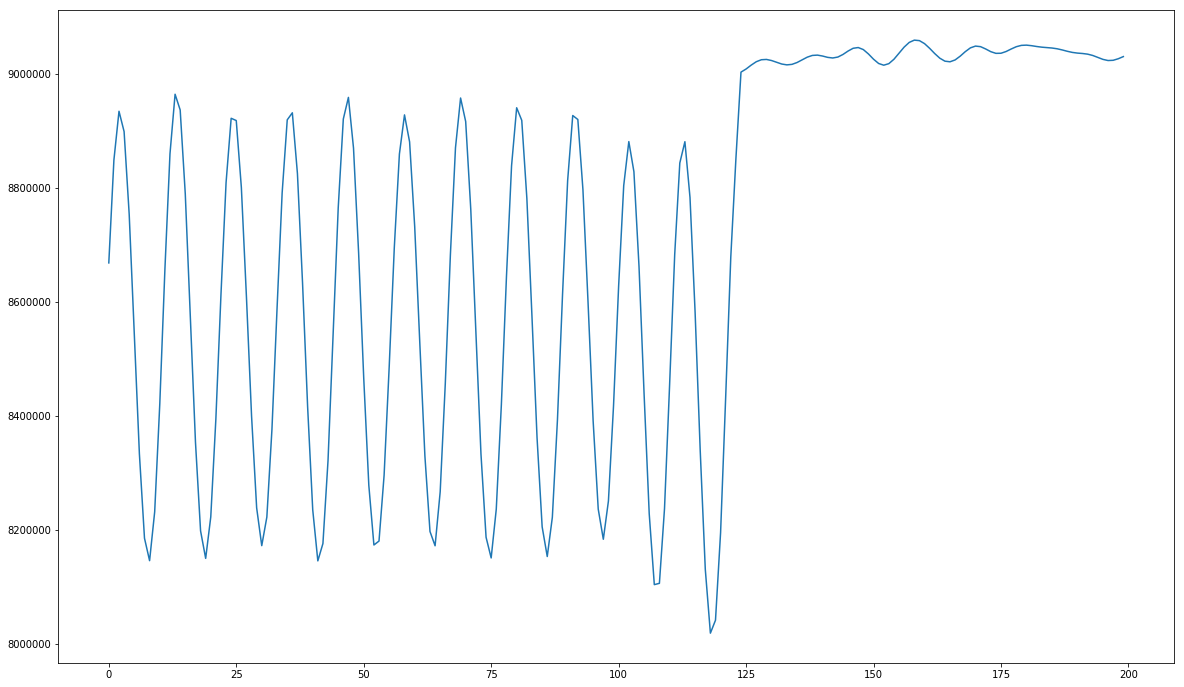

In [88]:
plt.plot(d[64900:65100])

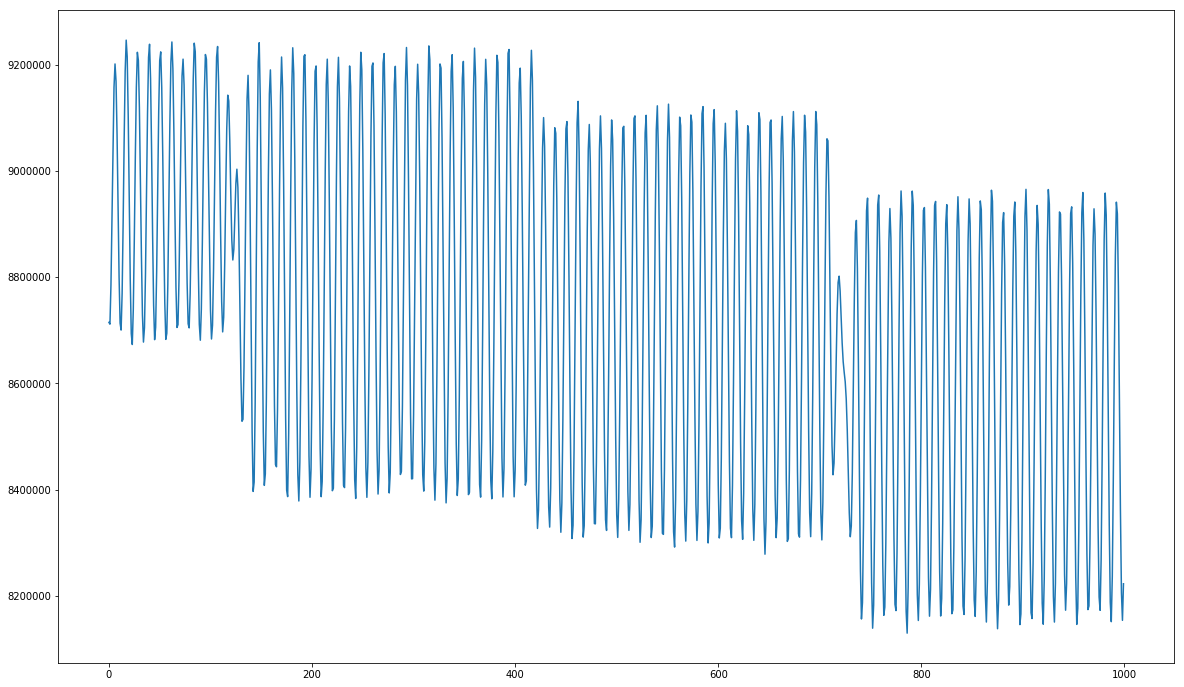

In [65]:
plt.plot(output[64500:65500])

In [28]:


params['freq'] = 40.0
#params['freq'] = 8 * 315 / 88
deemp_adj = .65
params['deemp'] = (120*deemp_adj, 320*deemp_adj)
filterset = prepare_video_filters(params)

output = dodemod(filterset, data1, usemtf=False)


In [19]:
output[50000:50005], output[-50005:-50000]

(array([ 8961391.79010572,  8899060.58410399,  8726489.09529676,
         8500717.23848124,  8292303.62756842]),
 array([ 9028969.09988602,  9030624.08412563,  9033781.37894778,
         9037224.0024213 ,  9039907.51277861]))

Below this is the less developed code to deal with NTSC framing and syncs.

In [73]:
# NTSC: filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks

output_sync = (output > (params['videorf_0ire'] + (params['hz_ire'] * -55))) & (output < (params['videorf_0ire'] + (params['hz_ire'] * -25)))

# Perform FFT convolution of above filter
output_syncf = np.fft.ifft(np.fft.fft(output_sync) * filterset['FPsync']).real

A plot of output_syncf here shows a nice pattern overall:

- Vsyncs reach 1.0 (and the mininum in those areas is ~0.23)
- regular hsyncs come in about 0.77 (the glitches are where the LD player "rewinds" for still frames)
- equalization pulses come in about 0.5

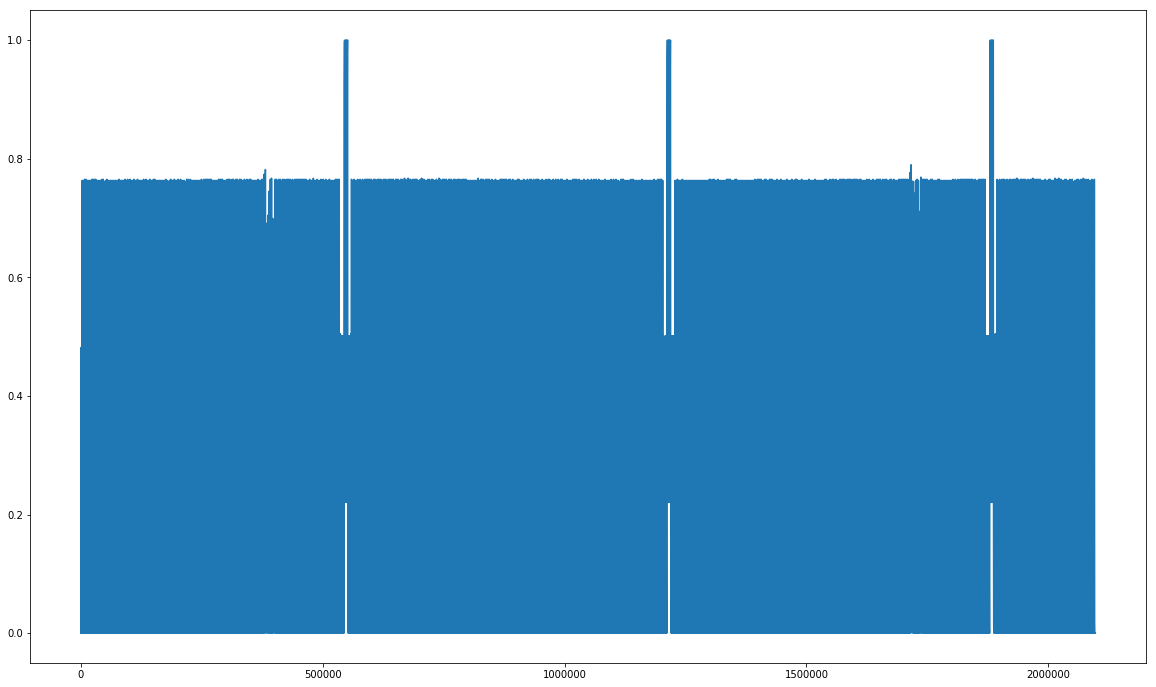

In [74]:
# This shows some nice patterns.  The glitches near the odd #'d syncs
plt.plot(output_syncf)

In [75]:
# state 1: find vsync and first full hsync.  determine which line it is as well...

loc = 1000000
imglen = (int)((filterset['freq_hz'] / 59.976) * 1.25)

if (loc + imglen) > len(output_syncf):
    print("get more data")

# find the next sync point.  should be > .9
syncloc = np.argmax(output_syncf[loc:loc+imglen]) + loc

if np.max(output_syncf[loc:loc+imglen]) < .9:
    print("oops.  can't find a good sync")

syncloc

1215151

In [76]:
def findburstfromsync(syncf, center):
    ilinepx = int(filterset['line_px'])

    if syncf[center] < .2:
        print('invalid location')
    try:
        scanarea = (ilinepx * 6)
        threshold = .15

        startsync = center - scanarea + np.where(syncf[center - scanarea:center] < threshold)[0][-1]
        # note: endsync usually includes the first equalization pulse
        endsync = center + np.where(syncf[center:center + scanarea] < threshold)[0][0]
    except:
        print('oh oh, sync ends not found')

    try:
        lastlinepresync = (startsync - (ilinepx * 4)) + np.where(syncf[startsync - (ilinepx * 4): startsync] > .55)[0][-1]
        # compute equalization length with .08 compensation factor
        presync_eqlen = ((startsync - lastlinepresync) / ilinepx) + .08
    except:
        print("error: couldn't find prev line")
        lastlinepresync = None
        presync_eqlen = None

    try:
        nextline = endsync + np.where(syncf[endsync: endsync + (ilinepx * 4)] > .55)[0][0]
        # the offset is larger here since the first equalization pulse is close enough to the end of vsync
        postsync_eqlen = ((nextline - endsync) / ilinepx) + .56
    except:
        print("error: couldn't find next line")
        nextline = None
        postsync_eqlen = None

    return (lastlinepresync, nextline, presync_eqlen, postsync_eqlen)

prevline, nextline, pregap, postgap = findburstfromsync(output_syncf, syncloc)

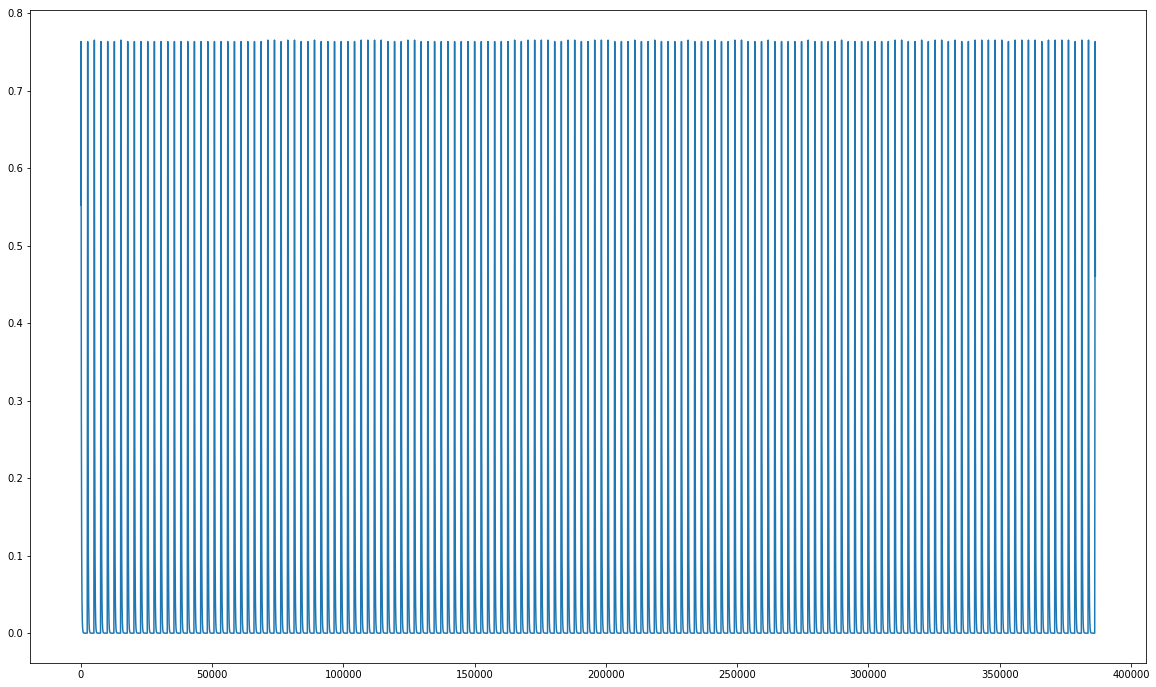

In [77]:
plt.plot(output_syncf[nextline:syncloc+399430])

In [78]:
reduced = (output - minn) / hz_ire_scale
output_u16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

In [79]:
# state 2: find the (rough) locations of each following line

ilinepx = int(filterset['line_px'])
lines = np.zeros((255 * ilinepx), dtype=np.uint16)

curloc = nextline

lineinfo = [curloc]
for i in range(0, 253):
    prevloc = curloc
    
    curloc += int(filterset['line_px'] * .9)
    offset = np.argmax(output_syncf[curloc:curloc + int(filterset['line_px'] * .2)])
    curloc += offset 
    
    # if the sync detection burst doesn't look good, reuse the last one
    is_validlinegap = inrange((curloc - prevloc), filterset['line_px'] * .997, filterset['line_px'] * 1.003)
    validaftersync = (np.max(output[curloc:curloc + 20]) < 8500000) and (np.min(output[curloc:curloc + 20]) >= 7600000)
    if (i >= 3) and (((output_syncf[curloc] < .7) and not is_validlinegap) or not validaftersync):
        print(i, curloc)
        curloc = prevloc + (lineinfo[-1] - lineinfo[-2])
        
    print(curloc, output[curloc], output[curloc+8])

    lineinfo.append(curloc)
    
    lines[i * ilinepx:(i * ilinepx)+(curloc - prevloc)] = output_u16[prevloc:curloc]
    
#    if (i == 119):
#        break

1230774 7749157.26827 8116641.6154
1233316 7788337.48916 8133733.12284
1235856 7773285.80651 8110241.06896
1238397 7766619.29953 8118678.16433
1240938 7746040.05369 8119588.95661
1243480 7786155.30255 8106581.47576
1246020 7747496.54801 8104967.92613
1248561 7776414.61387 8110662.9855
1251102 7756897.41467 8115020.83138
1253643 7749066.25478 8117238.21148
1256184 7772258.85048 8109192.21736
1258725 7744384.65866 8122190.65494
1261266 7767814.31668 8117713.44524
1263807 7759168.40744 8119092.18009
1266348 7757302.45934 8110454.42523
1268889 7767597.48514 8126050.18844
1271430 7761391.26022 8122394.07118
1273971 7751320.5624 8096019.12523
1276512 7770080.50526 8110992.94692
1279053 7756022.49616 8097064.60513
1281594 7736846.83442 8109365.72484
1284135 7727685.42787 8104990.21577
1286676 7754655.74093 8121031.6773
1289217 7780861.76959 8101456.3987
1291758 7748577.94048 8111219.92621
1294299 7771783.60347 8114116.41138
1296840 7795272.07833 8123618.99621
1299381 7764102.31578 8099067.292

In [80]:
def iretohz(ire):
    return 8100000+(hz_ire_scale*ire)

In [81]:
m20ire = 8100000-hz_ire_scale*20

In [82]:
# crude zero-crossing calculator.

def calczc(data, start_offset, target, count=10):
    if data[start_offset] < target:
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
    
    if len(locs) == 0:
        return None
        
    x = start_offset + locs[0]
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y


In [83]:
video_05 = filtfft(sps.butter(3, 0.5/22, 'low'))
output_lp = np.fft.ifft(np.fft.fft(output) * video_05).real[29:] 

In [84]:
lineinfo2 = []

for l in lineinfo:
    zc = calczc(output_lp, l - 5, m20ire, 20)
    
    if zc is None:
        lineinfo2.append(l)
        continue
        
    lineinfo2.append(zc)
    print(l, output[l], output[l + 1], output[l + 2])
    


1230774 7749157.26827 7819272.80873 7895163.60851
1233316 7788337.48916 7877251.73043 7963840.72067
1235856 7773285.80651 7832381.10013 7895410.5691
1238397 7766619.29953 7812619.53531 7871317.69529
1240938 7746040.05369 7808099.73489 7880952.11899
1243480 7786155.30255 7865264.90065 7948597.17295
1246020 7747496.54801 7820725.45129 7895488.84704
1248561 7776414.61387 7832192.76434 7892603.87639
1251102 7756897.41467 7820994.30005 7886831.01788
1253643 7749066.25478 7802504.1976 7869231.44391
1256184 7772258.85048 7837083.9719 7901487.21635
1258725 7744384.65866 7819298.8705 7897718.25761
1261266 7767814.31668 7828523.96506 7895621.01664
1263807 7759168.40744 7819130.65736 7882083.71457
1266348 7757302.45934 7826869.21145 7900371.98762
1268889 7767597.48514 7827218.49745 7888057.41263
1271430 7761391.26022 7819673.53653 7884340.42624
1273971 7751320.5624 7833180.47503 7918426.88688
1276512 7770080.50526 7833671.83075 7897804.2271
1279053 7756022.49616 7815695.18287 7889826.24647
128159

In [85]:
lineinfo2e = []

c = 0
for l in lineinfo:
    zc = calczc(output_lp, int(l - 10 + (filterset['line_px'] * 55 / 63.5)), m20ire, 200)
    
    if zc is None:
        lineinfo2e.append(l)
        continue
        
    lineinfo2e.append(zc)
    print(l, lineinfo2[c], lineinfo2e[c], output[l], output[l + 1], output[l + 2])
    c += 1
    


1230774 1228152 1228152 7749157.26827 7819272.80873 7895163.60851
1233316 1230776.14086 1233131.36269 7788337.48916 7877251.73043 7963840.72067
1235856 1233317.2198 1235672.2768 7773285.80651 7832381.10013 7895410.5691
1238397 1235858.24174 1238214.08151 7766619.29953 7812619.53531 7871317.69529
1240938 1238399.27029 1240754.49389 7746040.05369 7808099.73489 7880952.11899
1243480 1240940.3235 1243295.51146 7786155.30255 7865264.90065 7948597.17295
1246020 1243481.44228 1245836.64232 7747496.54801 7820725.45129 7895488.84704
1248561 1246022.51107 1248377.60834 7776414.61387 7832192.76434 7892603.87639
1251102 1248563.30529 1250918.32818 7756897.41467 7820994.30005 7886831.01788
1253643 1251104.50413 1253459.3808 7749066.25478 7802504.1976 7869231.44391
1256184 1253645.44236 1256000.35324 7772258.85048 7837083.9719 7901487.21635
1258725 1256186.44272 1258541.545 7744384.65866 7819298.8705 7897718.25761
1261266 1258727.27939 1261082.47836 7767814.31668 7828523.96506 7895621.01664
1263807 

1586554 1584014.28103 1586369.41349 7787272.26225 7842465.07945 7906428.57023
1589096 1586556.20806 1588911.34018 7777536.47641 7840703.70047 7910930.32932
1591638 1589098.19397 1591453.30239 7774376.99905 7860940.64175 7944576.67612
1594179 1591640.2382 1593995.39657 7739639.24035 7797296.09698 7858669.05364
1596722 1594182.22898 1596537.28778 7765142.22889 7831287.87796 7910193.29148
1599264 1596724.29529 1599079.07222 7770540.06495 7847666.9061 7928747.25041
1601806 1599266.10188 1601621.17473 7787648.36215 7862537.47848 7930067.07967
1604348 1601808.15653 1604163.00276 7795211.2102 7856699.92965 7921274.50518
1606889 1604350.23386 1606705.22967 7720989.97419 7796728.24044 7876640.77447
1609432 1606892.13996 1609247.25132 7793044.41858 7872005.39576 7950616.57365
1611974 1609433.90777 1611789.07449 7785358.54467 7862868.91752 7937366.6943
1614515 1611976.12543 1614331.3278 7751978.17742 7810876.26427 7876670.5155
1617057 1614517.9561 1616873.13011 7732710.56486 7801401.31844 7880100

In [86]:
# experiment:  filter color burst data for easier alignment

In [87]:
video_cburst = filtfft(sps.butter(2, [(300/88.0)/22, (330/88.0)/22], 'bandpass'))


In [88]:
output_cburst = np.fft.ifft(np.fft.fft(output - 8100000) * video_cburst).real[98:] + 8100000

In [89]:
calczc(output_lp, int(lineinfo2[250])-80, m20ire, 200), calczc(output, int(lineinfo2[250])-80, m20ire, 200)

(1863708.478109119, 1863707.4095698551)

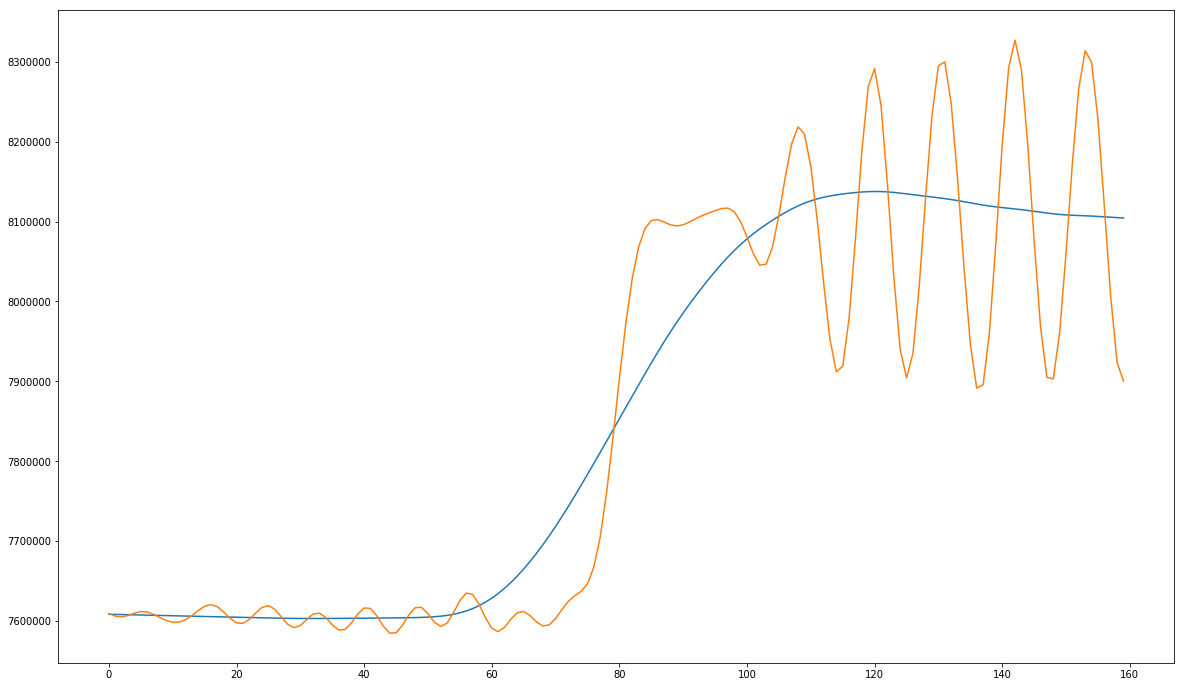

In [90]:
plt.plot(output_lp[int(lineinfo2[250]-80):int(lineinfo2[250])+80])
plt.plot(output[int(lineinfo2[250])-80:int(lineinfo2[250])+80])
#plt.plot(output[int(lineinfo2[50]):int(lineinfo2[51])])

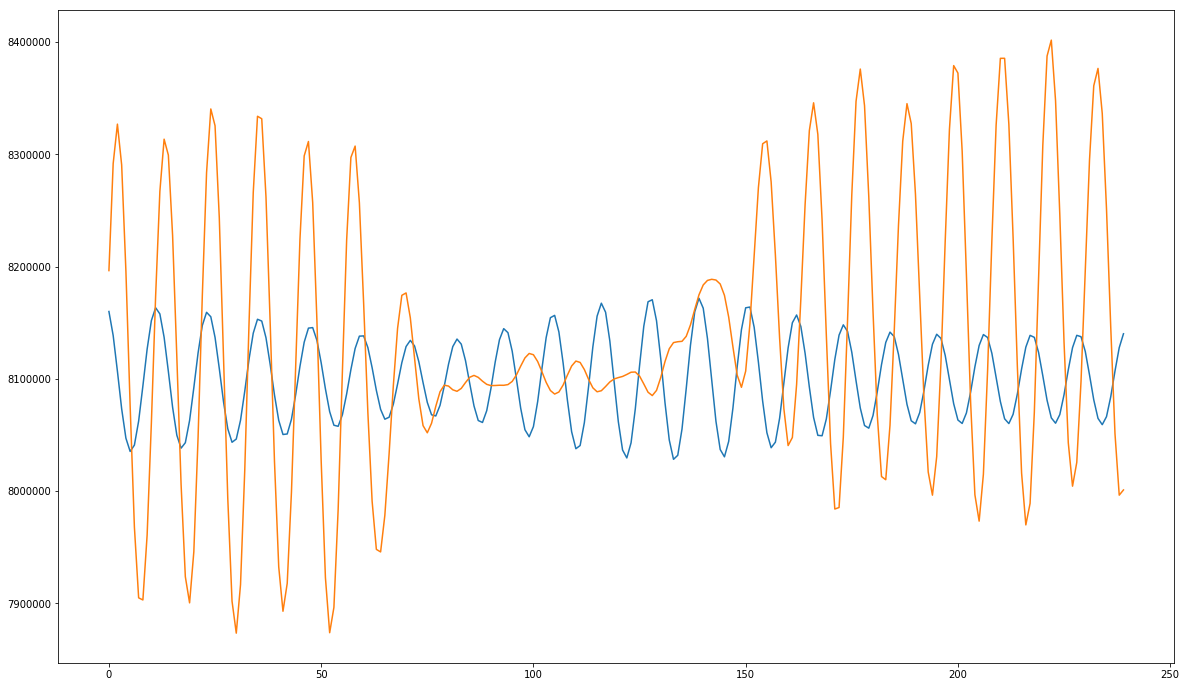

In [91]:
plt.plot(output_cburst[int(lineinfo2[250]+60):int(lineinfo2[250])+300])
plt.plot(output[int(lineinfo2[250])+60:int(lineinfo2[250])+300])
#plt.plot(output[int(lineinfo2[50]):int(lineinfo2[51])])

In [92]:
lineinfo2 = []

for l in lineinfo:
    zc = calczc(output_lp, l - 5, m20ire, 20)
    
    if zc is None:
        lineinfo2.append(l)
        continue
        
    lineinfo2.append(zc)
    print(l, output[l], output[l + 1], output[l + 2])
    


1230774 7749157.26827 7819272.80873 7895163.60851
1233316 7788337.48916 7877251.73043 7963840.72067
1235856 7773285.80651 7832381.10013 7895410.5691
1238397 7766619.29953 7812619.53531 7871317.69529
1240938 7746040.05369 7808099.73489 7880952.11899
1243480 7786155.30255 7865264.90065 7948597.17295
1246020 7747496.54801 7820725.45129 7895488.84704
1248561 7776414.61387 7832192.76434 7892603.87639
1251102 7756897.41467 7820994.30005 7886831.01788
1253643 7749066.25478 7802504.1976 7869231.44391
1256184 7772258.85048 7837083.9719 7901487.21635
1258725 7744384.65866 7819298.8705 7897718.25761
1261266 7767814.31668 7828523.96506 7895621.01664
1263807 7759168.40744 7819130.65736 7882083.71457
1266348 7757302.45934 7826869.21145 7900371.98762
1268889 7767597.48514 7827218.49745 7888057.41263
1271430 7761391.26022 7819673.53653 7884340.42624
1273971 7751320.5624 7833180.47503 7918426.88688
1276512 7770080.50526 7833671.83075 7897804.2271
1279053 7756022.49616 7815695.18287 7889826.24647
128159

In [93]:
# now to get fine sync!

In [94]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = int(begin)
        iend = int(end)
        linelen = end - begin

        dist = iend - ibegin + 0
        
        sfactor = dist / tgtlen
        
        arr, step = np.linspace(0, dist, num=dist + 1, retstep=True)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist + 1])
        arrout = np.linspace(begin - ibegin, linelen + (begin - ibegin), tgtlen + 1)

        return interpolate.splev(arrout, spl)[:-1]
    

x = np.arange(0, 400)
scale(x, 50.5, 60.5, 10)

array([ 50.5,  51.5,  52.5,  53.5,  54.5,  55.5,  56.5,  57.5,  58.5,  59.5])

In [95]:
def downscale(data, lineinfo):
    dsout = np.zeros((len(lineinfo) * ilinepx), dtype=np.double)    

    sfactor = []

    for l in range(0, len(lineinfo) - 1):
#        scaled = scale(data, lineinfo[l] + 0, lineinfo[l + 1], 910)
#        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / 910)
        scaled = scale(data, lineinfo[l][0], lineinfo[l][1], 910)
        sfactor.append((lineinfo[l][1] - lineinfo[l][0]) / 910)

        dsout[l * 910:(l + 1)*910] = scaled
        
    return dsout, sfactor

#lines, sfactor = downscale(output_cburst, lineinfo3)
    
#reduced = (lines - minn) / hz_ire_scale
#lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)


In [96]:
#drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

In [97]:
def phasecorrect(sdata, lineinfo, mult = 0.25):
    loutput = []
    errors = []

    #loutput.append(lineinfo[0])
    for l in range(0, len(lineinfo) - 1):
        subset = sdata[l * 910: (l + 1) * 910][5:60]

        if (np.min(subset) < 7600000) or (np.max(subset) > 8500000):
            loutput.append(lineinfo[l])
            errors.append(0)
            continue
        
        peaks = np.where(np.abs(subset - 8100000) > 80000)[0]
        toffset = 0

        for loc in peaks:
            zp = calczc(subset, loc, 8100000)

            if zp is not None:
                offset = (zp - loc - 1)
                toffset += offset
            else:
                offset = 0

    #        print(zp, offset)

        errors.append(toffset)
        #print(l, toffset / len(peaks) * sfactor[l])

        if len(peaks):
            loutput.append(lineinfo[l] - ((toffset * mult) / len(peaks) * sfactor[l]))
        else:
            loutput.append(lineinfo[l])

    loutput.append(lineinfo[-1])
    
    return loutput, errors

In [98]:
def calcerr(subset):
    black = np.mean(subset)
    
    peaks = np.where(np.abs(subset - black) > 100000)[0]
    toffset = 0
    noffsets = 0

    for loc in peaks:
        zp = calczc(subset, loc, black)

        #print(loc, subset[loc], zp)
        
        if zp is not None:
            offset = (zp - loc - 1)
            toffset += offset
            noffsets += 1
        else:
            offset = 0
            
    try:
        return toffset / noffsets
    except:
        return 0


In [99]:
lineinfo_tmp = lineinfo2.copy()
#lineinfo3 = [(lineinfo2[0], lineinfo[1])]
lineinfo3 = [(lineinfo2[0], lineinfo[1])]
badburst = np.zeros_like(lineinfo_tmp)
finalsnr = []

for l in range(1, len(lineinfo2) - 1):
    # hsync check
    scaled = scale(output, lineinfo_tmp[l - 1], lineinfo_tmp[l], 910) 
    subset = scaled[850:910]
    if (np.max(subset) > iretohz(10)) or (np.min(subset) < iretohz(-50)):
        badburst[l] = 1
    
    # color burst check
    scaled = scale(output, lineinfo_tmp[l], lineinfo_tmp[l + 1], 910) 
    subset = scaled[5:60]
    
    #print(l, np.min(subset), np.max(subset))
    if (np.max(subset) > iretohz(35)) or (np.min(subset) < iretohz(-35)):
        badburst[l] = 1

for l in range(1, len(lineinfo2) - 1):
    for i in range(0, 5):
        # compute 1.2x
        linelen = lineinfo_tmp[l + 1] - lineinfo_tmp[l]
        line12end = lineinfo_tmp[l] + (linelen * 1.2)

        scaled = scale(output, lineinfo_tmp[l], line12end, 1092) # 1092 is 1.2x 910
#        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / 910)

#        lineinfo_tmp[l] -= (offset1 * (linelen / 910) * (.5 / (i + 1)))
        #lineinfo3[l + 1] += (offset1 * (linelen / 910) * .25)
        if not badburst[l]:
            offset1 = calcerr(scaled[5:60])
            lineinfo_tmp[l] += (offset1 * (linelen / 910) * .5)
        else:
            offset1 = None
        if not badburst[l + 1]:
            offset2 = calcerr(scaled[915:970])
            lineinfo_tmp[l + 1] += ((offset2) * (linelen / 910) * .5)
        else:
            offset2 = None

        print(l, i, lineinfo_tmp[l], offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))

            
    lineinfo3.append((lineinfo_tmp[l], lineinfo_tmp[l + 1]))
    linelen = lineinfo3[l][1] - lineinfo3[l][0]
    line12end = lineinfo3[l][0] + (linelen * 1.2)

    scaled = scale(output, lineinfo3[l][0], line12end, 1092) # 1092 is 1.2x 910
    offset1 = calcerr(scaled[0:60])
    offset2 = calcerr(scaled[910:970])
    finalsnr.append(calcsnr((scaled[10:50] + scaled[920:960]) / 2))
    print(l, 'f', offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))
        
#    print(lineinfo_tmp[l + 1], lineinfo3[l][1])
    lineinfo_tmp[l + 1] = lineinfo3[l][1]

finalsnr = []    
    
for i in range(1, len(lineinfo2) - 1):
    if badburst[i] and not (badburst[i - 1] or badburst[i + 1]):
        print(i, lineinfo3[i - 1], lineinfo3[i], lineinfo3[i + 1])
        print((lineinfo3[i - 1][0] + lineinfo3[i + 1][0]) / 2)
        lineinfo3[i] = ((lineinfo3[i - 1][0] + lineinfo3[i + 1][0]) / 2, lineinfo3[i][1])
        lineinfo3[i - 1] = (lineinfo3[i - 1][0], (lineinfo3[i - 1][0] + lineinfo3[i + 1][0]) / 2)

    linelen = lineinfo3[i][1] - lineinfo3[i][0]
    line12end = lineinfo3[i][0] + (linelen * 1.2)
        
    scaled = scale(output, lineinfo3[i][0], line12end, 1092) # 1092 is 1.2x 910
    offset1 = calcerr(scaled[0:60])
    offset2 = calcerr(scaled[910:970])
    finalsnr.append(calcsnr((scaled[10:50] + scaled[920:960]) / 2))
    print(i, 'f', offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))
        
    
lineinfo3.append((lineinfo2[-1], lineinfo2[-1] + linelen))
#lineinfo3.append(lineinfo2[-1])

1 0 1230776.50427 0.260281152658 0.295391462592 40.5971784621
1 1 1230776.74864 0.175028449703 0.136952927553 40.1959202964
1 2 1230776.83696 0.0632579444835 0.0453333965694 40.679335318
1 3 1230776.86143 0.0175247161608 0.0127072246964 40.8251133173
1 4 1230776.86771 0.00449490452302 0.00351656658453 40.8543334359
1 f 0.0378146444856 0.00884808651708 40.8598448182
2 0 1233317.92665 0.012366112131 0.250633630329 32.6705725701
2 1 1233317.92387 -0.00199006963089 0.168569778373 36.9567489252
2 2 1233317.91783 -0.00432720461587 0.0583230157862 40.5357821904
2 3 1233317.91421 -0.00259304068231 0.014401614511 41.2740738
2 4 1233317.91267 -0.00109781113894 0.00354153429428 41.3425785323
2 f 0.00743510143154 0.049144092619 41.3501228866
3 0 1235858.94959 0.0116221488112 0.250817536536 32.6742791108
3 1 1235858.94676 -0.00202736391619 0.168082894646 37.0397355298
3 2 1235858.94079 -0.00427351036494 0.0571736355027 40.7405874567
3 3 1235858.93725 -0.00253879242772 0.0148941365958 41.5163625079


23 2 1286678.72502 -0.00115238125618 0.00827135960191 40.8748781113
23 3 1286678.72428 -0.000530443071564 0.00207526655995 40.9011233136
23 4 1286678.72399 -0.000206002533008 0.000516537431522 40.9049352678
23 f 0.0166615856098 0.133203065998 40.9057184972
24 0 1289219.70045 0.00645151008336 0.176043376717 36.6838365758
24 1 1289219.69768 -0.00198668741033 0.0615051117975 40.129238166
24 2 1289219.69494 -0.00196358682699 0.0161461354039 40.7876179846
24 3 1289219.69361 -0.000947364978284 0.00417077336115 40.8321849121
24 4 1289219.69309 -0.000376447152727 0.00107786069672 40.8319353696
24 f 0.132940623046 0.0182315475265 40.8308180916
25 0 1291760.62668 0.00212443703671 0.100056008378 40.48256756
25 1 1291760.62454 -0.00153241191291 0.0288707632087 42.6820099755
25 2 1291760.623 -0.00110365398249 0.00730371164591 42.9453238167
25 3 1291760.6223 -0.000499795686463 0.00177784670025 42.9640337657
25 4 1291760.62203 -0.000192810198554 0.000426097925316 42.964876452
25 f 0.0179951549663 0.0

46 1 1345122.73046 -0.00209256734204 0.157427859171 37.667169303
46 2 1345122.72473 -0.00410733399182 0.0528397270469 41.4460319839
46 3 1345122.72136 -0.00241146420098 0.014886846903 42.2903937237
46 4 1345122.71988 -0.00105747666424 0.00407515079835 42.3990141776
46 f 0.171962256787 0.0328024368914 42.415501765
47 0 1347663.86499 0.00720609658218 0.217247991021 35.88438658
47 1 1347663.86169 -0.00235946393061 0.0837182490358 40.5737401313
47 2 1347663.85812 -0.00255738344131 0.0237680915888 41.8824149538
47 3 1347663.85626 -0.00133220617705 0.00644768796302 41.9825342265
47 4 1347663.85547 -0.000566235349881 0.00173792726285 41.9786543361
47 f 0.0315379262256 0.0525867405696 41.9745448481
48 0 1350205.07326 0.0102410512449 0.284932747797 33.1599104583
48 1 1350205.06923 -0.00288257591273 0.128139940395 38.5020053113
48 2 1350205.06411 -0.0036681374637 0.0386427497006 41.1463100302
48 3 1350205.06133 -0.00199161289333 0.00949986687337 41.5582698963
48 4 1350205.06016 -0.00083606572902

88 f 0.01319931543 0.050577653235 40.0484513022
89 0 1454392.20387 0.00393623289588 0.145417896744 37.0843443218
89 1 1454392.20133 -0.00182149047058 0.0456949228343 39.5268069961
89 2 1454392.19915 -0.00156024196899 0.0122840006452 39.8479632319
89 3 1454392.19808 -0.000764950653885 0.00325004917665 39.8642375182
89 4 1454392.19764 -0.000315967106177 0.00086726993811 39.8620790724
89 f 0.050173863927 0.00937646577161 39.8608421646
90 0 1456933.57044 0.00477576271394 0.167962392224 36.4717008588
90 1 1456933.56747 -0.00212879248436 0.058011435706 40.1897595016
90 2 1456933.56478 -0.00192769539184 0.0152017076671 41.0579805749
90 3 1456933.56347 -0.00093748325096 0.00384110950684 41.1661154145
90 4 1456933.56294 -0.000378954894092 0.000981353436423 41.1831377702
90 f 0.00908036200566 -0.00368410470793 41.1869064581
91 0 1459474.98887 0.00624227357287 0.12075163838 39.0244404744
91 1 1459474.98789 -0.00069687491834 0.0380399166981 41.589957784
91 2 1459474.98645 -0.00103032741823 0.01019

111 f 0.0136703123736 0.0170666874597 42.8989768697
112 0 1512844.42929 0.00962501476868 0.25721298883 32.6357589904
112 1 1512844.42554 -0.00268542696925 0.173114026242 37.5035933301
112 2 1512844.41903 -0.00466593789295 0.0590867085957 42.3363249045
112 3 1512844.41522 -0.00273058484607 0.0160687626556 43.4890023592
112 4 1512844.41356 -0.00118933765753 0.00433146351441 43.5858727951
112 f 0.0160865381902 0.0401149024185 43.5886749535
113 0 1515385.98626 0.0111839239742 0.279323664921 33.3526133474
113 1 1515385.98276 -0.00250495161099 0.121740838011 38.902343979
113 2 1515385.97796 -0.00343785963082 0.0364705335085 41.4973371287
113 3 1515385.97534 -0.00187932741876 0.00938731041253 41.8441768237
113 4 1515385.97422 -0.000797662595957 0.00237980098641 41.869002039
113 f 0.0387000152279 -0.0022982780309 41.869825956
114 0 1517927.52736 0.0134335872954 0.220303578048 31.890906535
114 1 1517927.52625 -0.000792255716203 0.202206058185 35.2131769554
114 2 1517927.51971 -0.00468519200071 

134 2 1568762.5366 -0.00206227653332 0.0153114325639 43.2736767801
134 3 1568762.53524 -0.000971919569104 0.00378239355026 43.4432028688
134 4 1568762.5347 -0.00038226512597 0.000932913435049 43.4682917728
134 f 0.0451419627253 0.018439842824 43.4735324738
135 0 1571304.54002 0.00065627406302 -0.0256715819984 42.2919668313
135 1 1571304.54109 0.000769608484833 -0.00698256125993 42.5512738157
135 2 1571304.54163 0.000385188528865 -0.00182558478027 42.5854384808
135 3 1571304.54185 0.000155459791684 -0.000468846057052 42.5914766699
135 4 1571304.54193 5.67515327279e-05 -0.000118872917458 42.5928829044
135 f 0.0181682449193 0.0327549124634 42.593255075
136 0 1573846.4723 0.00327313289793 0.126755701849 38.2102104944
136 1 1573846.46983 -0.00176721664559 0.0395651878065 41.222204931
136 2 1573846.46788 -0.00139990373598 0.0106558956125 41.8377007442
136 3 1573846.46696 -0.00065855242939 0.00277561623039 41.9355450137
136 4 1573846.46659 -0.00026086846267 0.000714019345251 41.9556633133
136

157 1 1627228.48569 -0.000570133479391 0.00407796564007 41.9025853676
157 2 1627228.48532 -0.00026463953285 0.0011048498771 41.8939725759
157 3 1627228.48518 -0.000105249791672 0.000297342407792 41.8903224321
157 4 1627228.48512 -3.8688135697e-05 7.93223090375e-05 41.8891522223
157 f 0.00393363688865 -0.00167799975778 41.8888004965
158 0 1629770.68502 0.00227345306754 0.0793163954324 39.6325425639
158 1 1629770.68368 -0.00096524006739 0.0205997472254 40.7173698543
158 2 1629770.68264 -0.00074418277057 0.00492259684136 40.8384006547
158 3 1629770.68216 -0.000340586746872 0.00114777021984 40.8538943947
158 4 1629770.68198 -0.000132346509362 0.000264078228605 40.8568285168
158 f -0.0017438475298 0.0149526929214 40.8575354644
159 0 1632312.87582 -0.00227002021462 0.00715215185096 40.1555742852
159 1 1632312.87469 -0.000810220856895 0.00175406695848 40.1919250088
159 2 1632312.87431 -0.000269126439309 0.000431378214505 40.1988721244
159 3 1632312.87419 -8.58980061814e-05 0.000104648975884 4

201 2 1739104.64921 None -0.0750121036598 30.7236883876
201 3 1739104.64921 None -0.0213347674065 30.4179501806
201 4 1739104.64921 None -0.00602604595957 30.2815787365
201 f 0.115793665335 -0.0120139007134 30.2396280711
202 0 1741647.24333 0.00511094093701 0.0757614277768 30.667263225
202 1 1741647.24338 3.41693456426e-05 0.159642865039 31.7250164775
202 2 1741647.23853 -0.00346808366412 0.108697197482 34.1193632472
202 3 1741647.23363 -0.00350778147711 0.0326551760446 35.2305264475
202 4 1741647.23103 -0.00186514146861 0.0092953870542 35.3506803244
202 f -0.0111475103024 0.0217219807436 35.3589051423
203 0 1744189.93472 0.0072752132765 0.122331437845 36.458665308
203 1 1744189.93456 -0.000109723850996 0.0386363599722 37.8942721443
203 2 1744189.93338 -0.000844847651526 0.0111278896004 38.0225964741
203 3 1744189.93266 -0.00052178586465 0.0031627307666 38.0158770331
203 4 1744189.93231 -0.000244768098799 0.000895519779714 38.0093523759
203 f 0.0188119799875 0.0929340070948 38.00690792

223 f 0.0232351376716 0.050067008325 42.2405127224
224 0 1797590.06987 0.00602583983435 0.132191697532 38.0962638809
224 1 1797590.06831 -0.00112227184189 0.039877214805 40.6012151915
224 2 1797590.06659 -0.00122971919545 0.0103521392595 41.0372317993
224 3 1797590.06574 -0.000603261808554 0.00265860477416 41.0995893923
224 4 1797590.06541 -0.000241897728369 0.000678647400277 41.1118198193
224 f 0.0499413477597 0.00655475614816 41.114835595
225 0 1800133.07247 -0.00215424235016 -0.0470989146537 41.5054216423
225 1 1800133.073 0.00038522924251 -0.0136683849916 42.2197299066
225 2 1800133.07359 0.00041905289306 -0.00365628467798 42.3460014485
225 3 1800133.07388 0.000208267379245 -0.000955315445725 42.3723952106
225 4 1800133.074 8.44866475945e-05 -0.000246129413182 42.379066041
225 f 0.00650237162319 0.133066454206 42.3808928502
226 0 1802676.14484 0.00277822224842 0.125864353237 39.520708764
226 1 1802676.14216 -0.00192247578325 0.0379497455444 42.4256241955
226 2 1802676.14016 -0.0014

246 4 1853536.15177 -8.20658508627e-05 0.000164751715097 43.0191613474
246 f 0.0437688390555 -0.00261997960784 43.0189926345
247 0 1856079.26089 0.00100781327321 0.0238622328776 41.3437970071
247 1 1856079.26057 -0.000230515727938 0.00648559358651 41.4201370745
247 2 1856079.26027 -0.000213736469532 0.00173727740898 41.4201403127
247 3 1856079.26013 -0.00010270251477 0.000458376309679 41.4182150822
247 4 1856079.26007 -4.0944453131e-05 0.00012000024336 41.4175011164
247 f -0.00267919989412 0.0261903508226 41.4172831173
248 0 1858622.35307 0.000610146215081 -0.0254679226832 41.6662179173
248 1 1858622.35412 0.000749160958463 -0.00669288351947 41.8172992957
248 2 1858622.35465 0.000379763780459 -0.0017393114068 41.8291580467
248 3 1858622.35487 0.000156194034553 -0.000447591996 41.8299367499
248 4 1858622.35495 5.83620209666e-05 -0.000113870336752 41.8299492384
248 f 0.0261171306089 0.156866882789 41.8299363022
249 0 1861165.35685 -0.00182660840705 0.0219775096996 41.8854926029
249 1 186

212 f 0.124858246186 0.0388043939902 42.9072886223
213 f 0.038529886471 0.0488571213337 42.1754102028
214 f 0.0486522149076 0.00286400046168 41.7018205101
215 f 0.00243070254001 0.0256568666905 41.3991750534
216 f 0.0255021529919 0.0227088361279 42.1634594223
217 f 0.0224988703156 0.0224228726425 42.3787740448
218 f 0.0221942841694 0.0218460520288 43.1147752787
219 f 0.0215246065876 0.032542073157 40.492328069
220 f 0.0321894767606 -0.00185626976043 41.3524401982
221 f -0.00202868312128 -0.00330047043453 42.7457653139
222 f -0.00354445229668 0.0233129265525 42.3178853769
223 f 0.0232351376716 0.050067008325 42.2405127224
224 f 0.0499413477597 0.00655475614816 41.114835595
225 f 0.00650237162319 0.133066454206 42.3808928502
226 f 0.133049070855 -4.26561217785e-05 42.8324795424
227 f -0.00026919260338 0.0175025330031 42.5590768662
228 f 0.0175629873116 0.0378544076723 42.7400527143
229 f 0.0378259371648 0.0193153776045 40.9138108568
230 f 0.0192582956258 0.0255266585885 40.928977617
231 

In [100]:
np.mean(finalsnr), np.min(finalsnr), np.argmin(finalsnr) + 1

(40.937958857257833, 17.857344249564896, 191)

In [101]:
finalsnr

[40.859844818191476,
 41.350122886553351,
 41.604726066108014,
 40.815865962928548,
 40.083877274238674,
 41.526107479984944,
 42.673474267849997,
 41.706297386851723,
 42.916805129978513,
 43.775028022623545,
 43.952542166575689,
 42.560413847410729,
 42.319885058467577,
 43.357132002703139,
 43.710215326326406,
 42.553804394163308,
 42.087380476643041,
 43.154812330143024,
 44.80029641797514,
 43.889649996791405,
 41.59835476274128,
 40.86406588799256,
 40.90571849718831,
 40.830818091571182,
 42.964789904592344,
 43.392852537750606,
 42.255073507037189,
 40.870876203042698,
 41.664279076924231,
 40.673960110043083,
 43.064486737171492,
 43.519429571943249,
 42.339055456022201,
 40.37982500084189,
 40.547595618724955,
 41.882558933688614,
 41.712776995861745,
 41.383310453654914,
 41.278651936006725,
 41.21763358241558,
 41.450349329073688,
 42.272942139438058,
 42.205046483222972,
 40.891900047379806,
 41.663771521253949,
 42.415501764961761,
 41.974544848130783,
 41.609947140718894

In [102]:
for i in range(len(lineinfo3) - 1):
    print(i, lineinfo3[i + 1][0] - lineinfo3[i][1], lineinfo3[i])

0 2.86770788068 (1228152, 1230774)
1 0.00328817707486 (1230776.8677078807, 1233317.9093862495)
2 0.00235885707662 (1233317.9126744266, 1235858.9333691769)
3 0.00292344903573 (1235858.935728034, 1238399.9608154704)
4 0.000806263880804 (1238399.9637389195, 1240940.9726122988)
5 0.00369106559083 (1240940.9734185627, 1243482.0209363273)
6 0.00120354862884 (1243482.0246273929, 1246022.9956670878)
7 0.0021288304124 (1246022.9968706365, 1248563.9787939172)
8 -0.00102129741572 (1248563.9809227476, 1251104.9535685745)
9 0.00493650068529 (1251104.9525472771, 1253645.9973427306)
10 -0.00176254683174 (1253646.0022792313, 1256186.9278231817)
11 0.0039534792304 (1256186.9260606349, 1258727.9446353661)
12 0.000267398776487 (1258727.9485888453, 1261268.9038086035)
13 0.00350045668893 (1261268.9040760023, 1263809.9178820108)
14 -0.00166118540801 (1263809.9213824675, 1266350.8474074446)
15 0.000625915825367 (1266350.8457462592, 1268891.8557460371)
16 0.00116214854643 (1268891.8563719529, 1271432.8679099

40.9379588573
(230230,)
uint8 (253, 910) (253, 910)


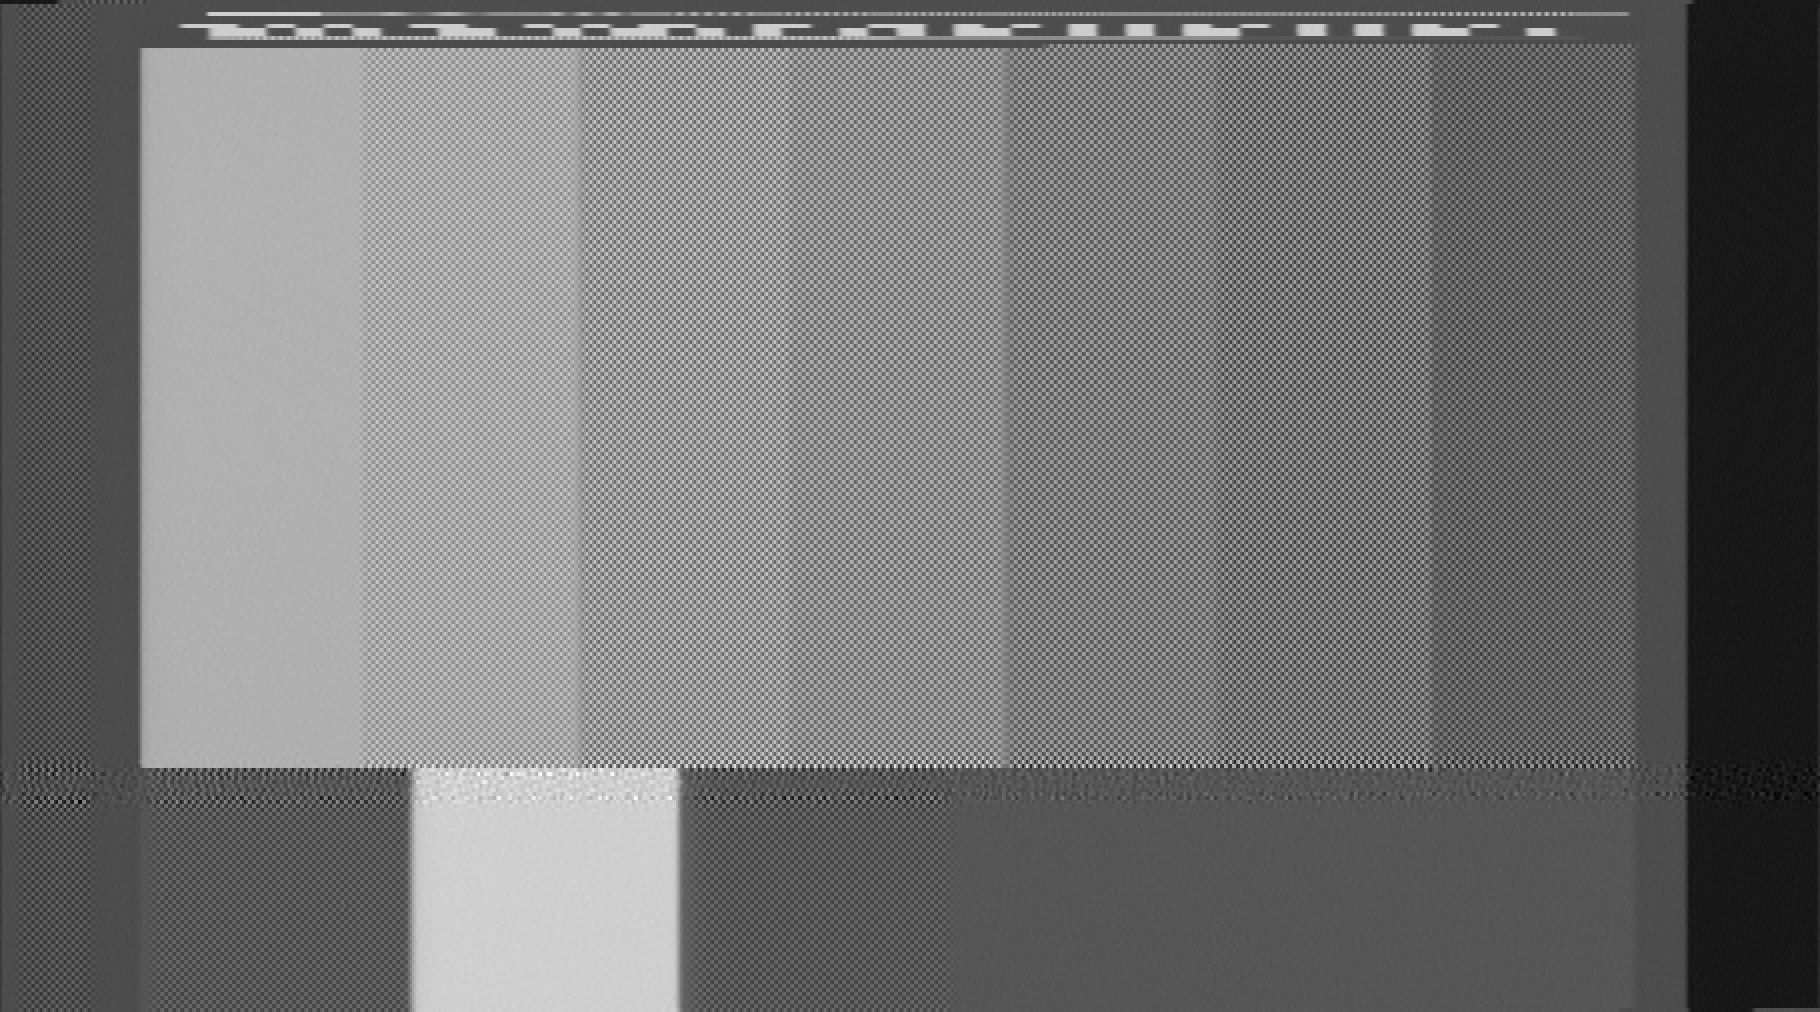

In [104]:
print(np.mean(finalsnr))
lines, sfactor = downscale(output, lineinfo3)

reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

In [105]:
lineinfo3

[(1228152, 1230774),
 (1230776.8677078807, 1233317.9093862495),
 (1233317.9126744266, 1235858.9333691769),
 (1235858.935728034, 1238399.9608154704),
 (1238399.9637389195, 1240940.9726122988),
 (1240940.9734185627, 1243482.0209363273),
 (1243482.0246273929, 1246022.9956670878),
 (1246022.9968706365, 1248563.9787939172),
 (1248563.9809227476, 1251104.9535685745),
 (1251104.9525472771, 1253645.9973427306),
 (1253646.0022792313, 1256186.9278231817),
 (1256186.9260606349, 1258727.9446353661),
 (1258727.9485888453, 1261268.9038086035),
 (1261268.9040760023, 1263809.9178820108),
 (1263809.9213824675, 1266350.8474074446),
 (1266350.8457462592, 1268891.8557460371),
 (1268891.8563719529, 1271432.8679099549),
 (1271432.8690721034, 1273973.8654565956),
 (1273973.8684803944, 1276514.7888502863),
 (1276514.78726781, 1279055.7651475957),
 (1279055.7644556006, 1281596.772658441),
 (1281596.7731283628, 1284137.7721090764),
 (1284137.7738977978, 1286678.724194004),
 (1286678.7239936553, 1289219.69144555

In [117]:
lineinfo[3], lineinfo[4]

(1235856, 1238397)

(42.376171624789663, 39.689563095776528)

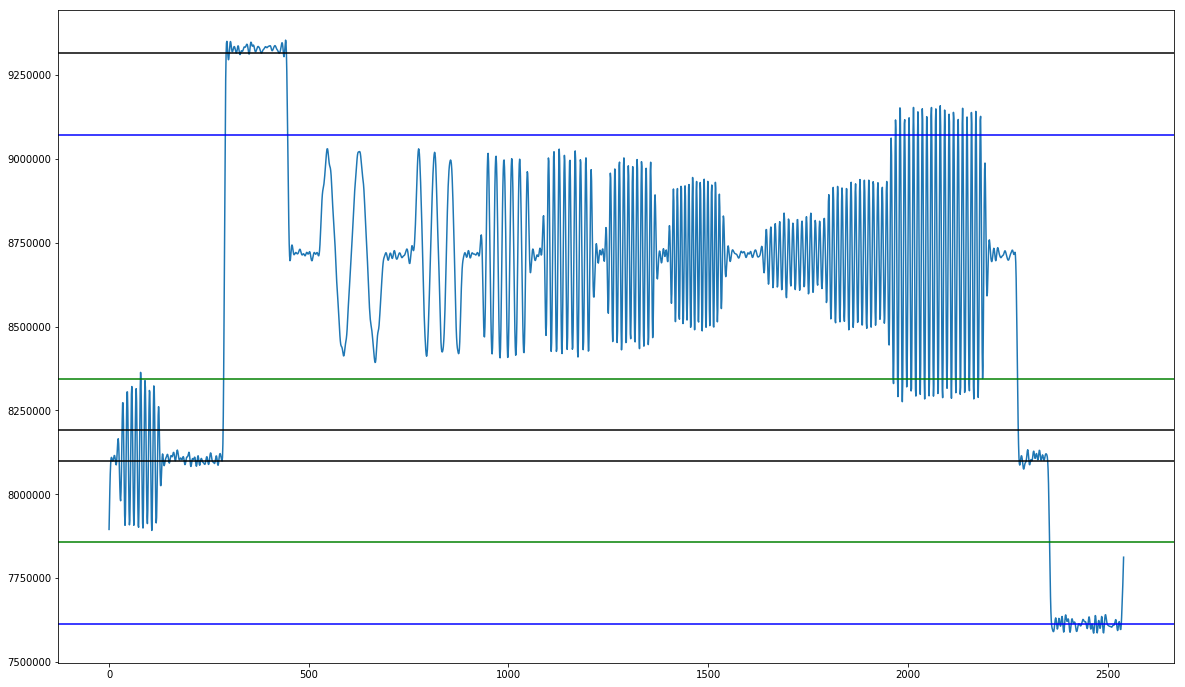

In [132]:
l = 3
x = output[int(lineinfo3[l][0]):int(lineinfo3[l+1][0])]
lineplot(x, filterset)
calcsnr(x[300:400]), calcsnr(x[2400:2530])

(17.068356541567301, 33.604419611911901)

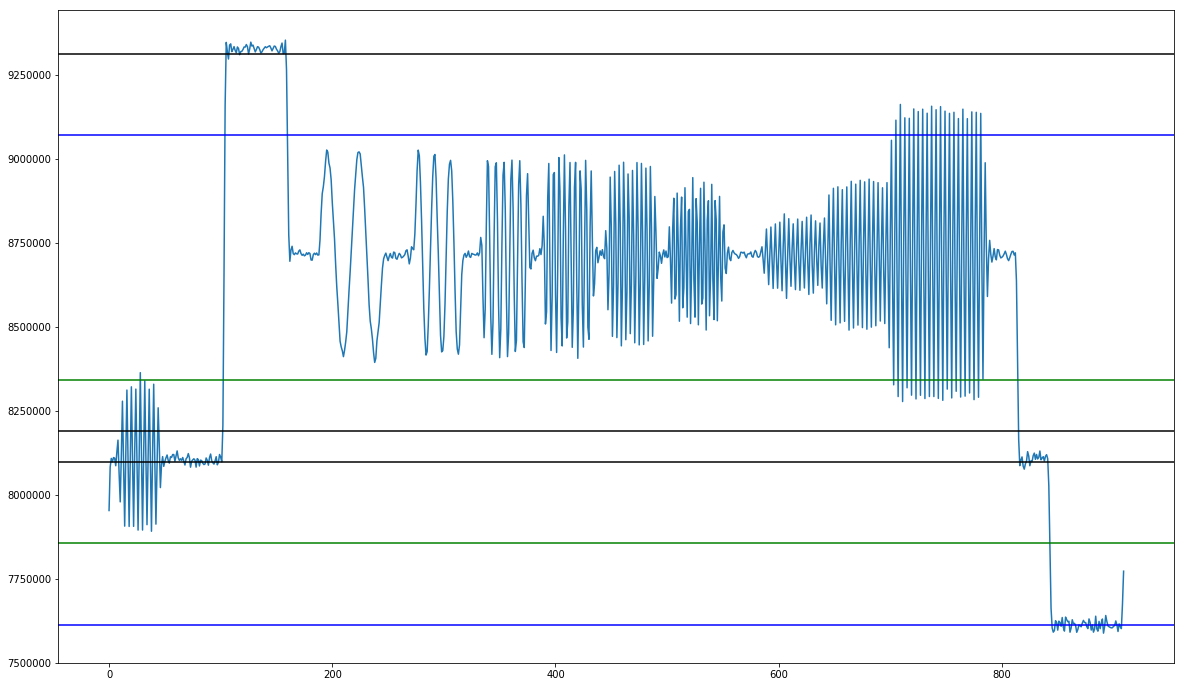

In [121]:
l = 3
x = lines[l * 910:(l + 1) * 910]
lineplot(x, filterset)
calcsnr(x[300:400]), calcsnr(x[850:])

In [695]:
snr = []
zcstart = []
zcend = []
zclen = []
for l in range(2, 250):
    preline = lines[(l * 910) - 20: (l * 910) + 20]
    _line = lines[(l * 910):(l + 2) * 910]
    
    x = lines[(910*l)+0:(910*l)+80]
    y = (x + lines[(910*l)+910:(910*l)+990]) / 2
    #plt.plot(y)

    zcstart.append(calczc(preline, 0, m20ire, 40) - 20)
    zcend.append(calczc(_line, 830, m20ire, 40))
    nextstart = calczc(_line, 900, m20ire, 40)
    zclen.append(nextstart - zcend[-1])
    snr.append(calcsnr(y[15:50]))
    print(l, calczc(preline, 0, m20ire, 40) - 20, calczc(_line, 830, m20ire, 40), calczc(_line, 900, m20ire, 40), calcsnr(y[15:50]))

2 -0.154741137918 845.368979898 909.861959977 37.4950262196
3 -0.138040022963 845.484546213 909.9074071 39.53515591
4 -0.0925929003539 845.450885029 909.909596074 38.2483850861
5 -0.0904039259235 845.431623837 909.909069945 38.7810154812
6 -0.090930054506 845.442284106 909.86090586 38.7791257511
7 -0.139094139965 845.425737295 909.832417702 39.7752201802
8 -0.167582298308 845.27221555 909.925389741 38.3505643762
9 -0.0746102585259 845.027630874 909.812592829 34.1564994399
10 -0.187407171451 845.224789305 909.883270826 38.0456201704
11 -0.116729174283 845.393663928 909.831584864 37.2948848883
12 -0.168415135823 845.195340354 909.928115571 36.7303025515
13 -0.0718844287775 845.338972519 909.837234703 36.2558223715
14 -0.162765296637 845.386983961 909.95733255 36.5790130216
15 -0.0426674502844 845.357508123 909.888763879 40.4586957605
16 -0.111236121343 845.278593138 909.928385346 37.6993434262
17 -0.0716146538122 845.114413832 909.880244413 38.2993437394
18 -0.119755586585 845.315334887 

In [696]:
np.mean(zclen), np.std(zclen)

(64.535136767752377, 0.11737262082938797)

In [697]:
np.std(zcstart), np.std(zcend), np.mean(snr)

(0.062264975967787954, 0.10891155743135103, 38.206862345726094)

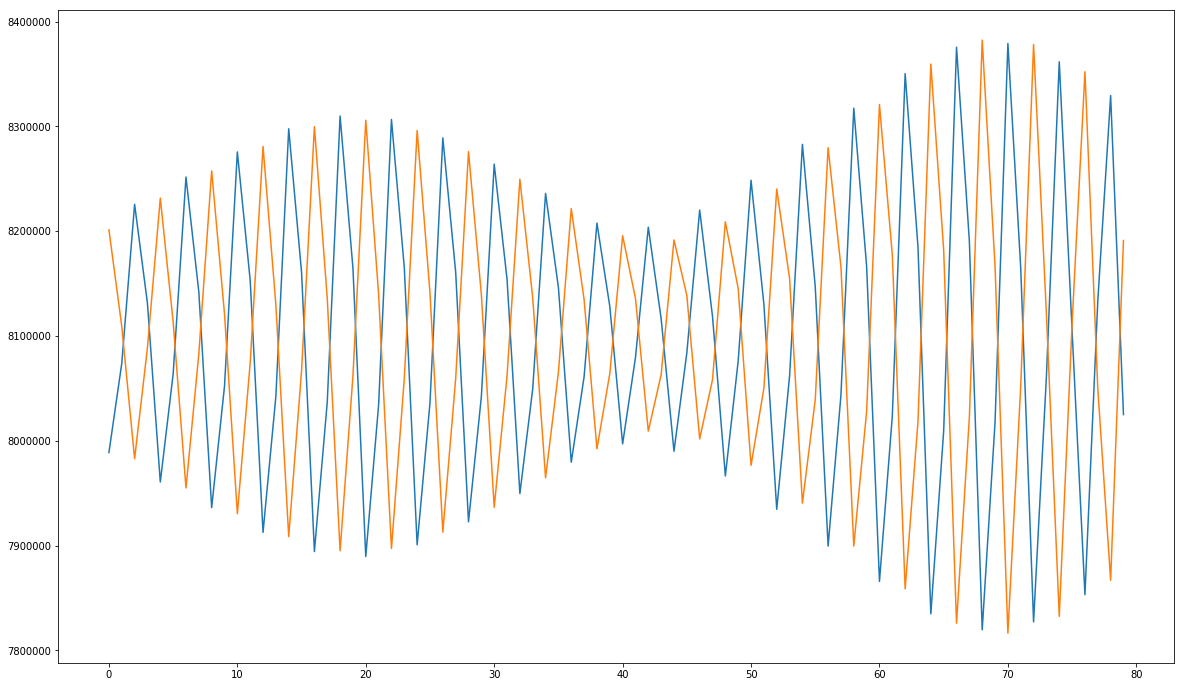

In [913]:
l = 17
x = lines[(910*l)+0:(910*l)+80]
plt.plot(x)
l = l + 1
x = lines[(910*l)+0:(910*l)+80]
plt.plot(x)


In [770]:
lineinfo_cur[100], lineinfo_cur[101]

(1160549.1033076106, 1163347.4488508701)

43.451705388955098

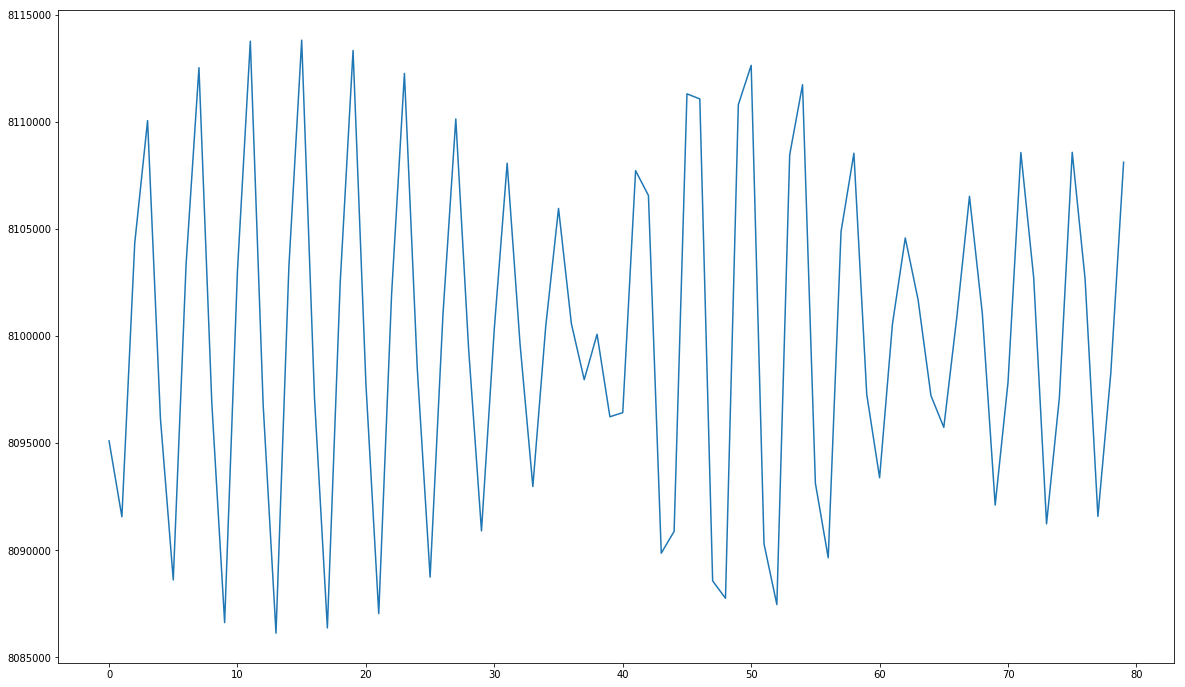

In [914]:
l = 17
x = lines[(910*l)+0:(910*l)+80]
#plt.plot(x)
l = l + 1
y = (x + lines[(910*l)+0:(910*l)+80]) / 2
plt.plot(y)
calcsnr(y[15:50])


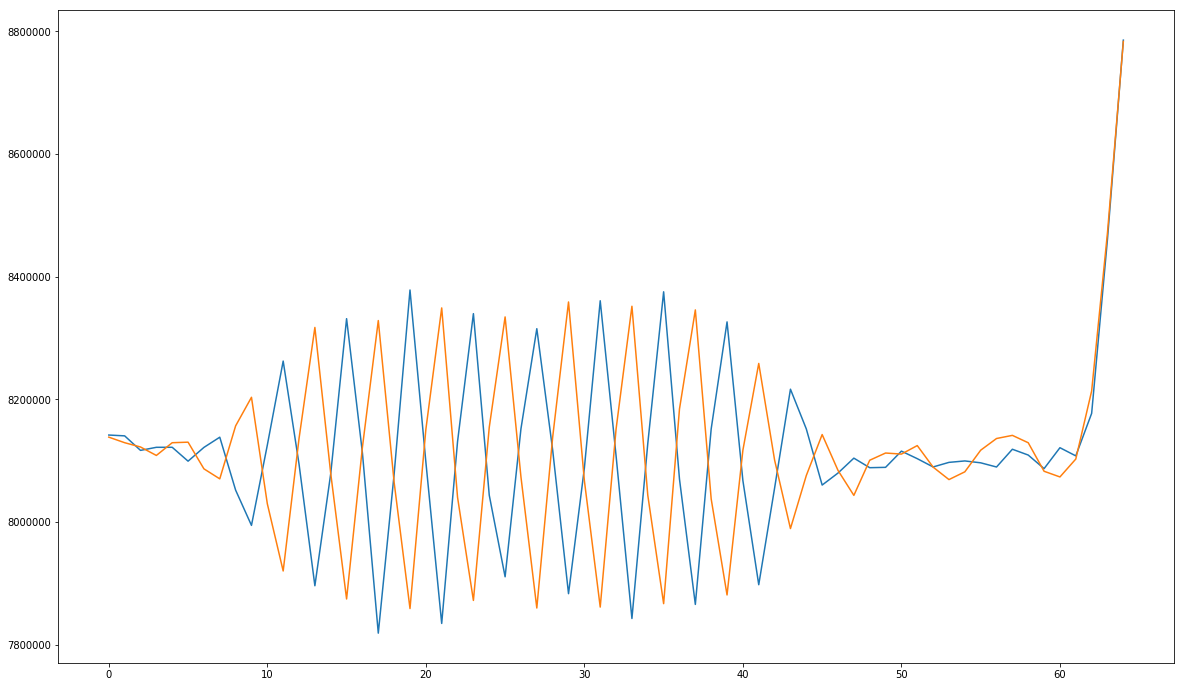

In [137]:
l = 50
x = lines[(910*l)+5:(910*l)+70]
plt.plot(x)
y = lines[(910*(l+1))+5:(910*(l+1))+70]
plt.plot(y)

22.0131165809


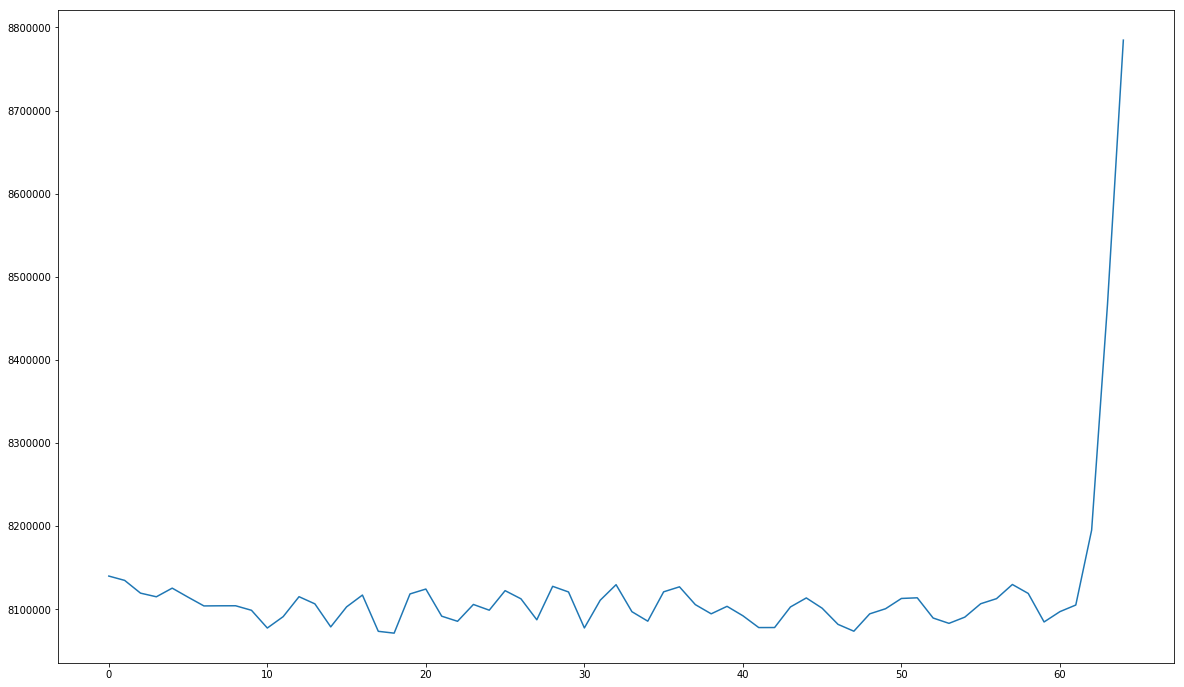

In [138]:
l = 50
x = lines[(910*l)+5:(910*l)+70] + lines[(910*(l+1))+5:(910*(l+1))+70]
plt.plot(x / 2)
calcsnr(x / 2)

(230230,)
uint8 (253, 910) (253, 910)


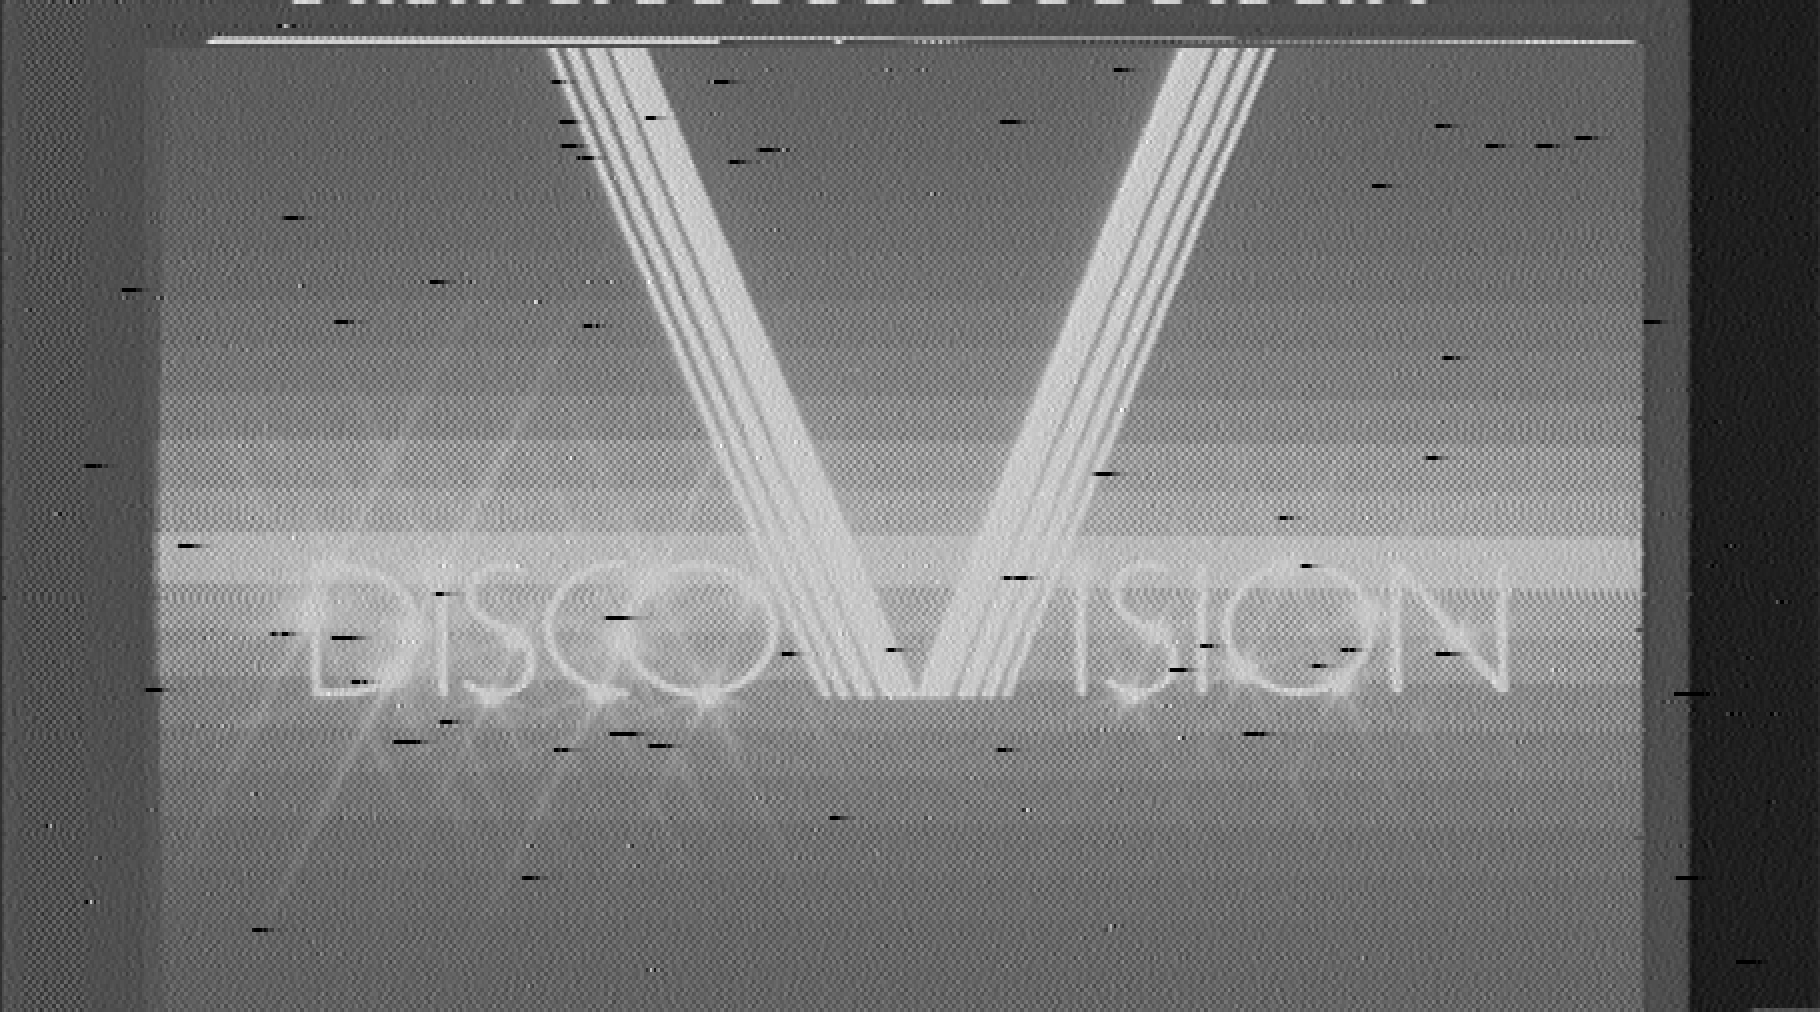

In [35]:
# Example of this code on a rotter :)
reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

In [36]:
# figure out where vsync is supposed to begin, assuming line start at ire -20:

In [37]:
910/63.5, 58.5*(910/63.5)

(14.330708661417322, 838.3464566929133)

In [38]:
begline = []
endline = []
for l in range(0, len(lineinfo_cur) - 1):
    cline = lines[l * 910:(l + 1) * 910]
    begline.append(calczc(cline, 0, 8000000, 5))
    endline.append(calczc(cline, 840, m20ire, 20))
    if (begline[-1] is None):
        print("b", l)
        begline[-1] = -1
    if (endline[-1] is None):
        print("e", l)
        endline[-1] = 844.25

e 173
e 219


In [39]:
np.min(begline), np.max(begline), np.mean(begline), np.argmax(begline), np.std(begline)

(0.36511998949632013,
 2.7357543924367347,
 0.76349998963594301,
 149,
 0.25001621551811237)

In [40]:
np.min(endline), np.max(endline), np.mean(endline), np.argmax(endline), np.std(endline)

(840.20959013105346,
 845.70162781330214,
 844.23547566598813,
 148,
 0.44573642405298891)

In [41]:
linegaps2 = np.diff(lineinfo2)
linegaps_end = np.diff(lineinfo_cur)

In [42]:
np.mean(linegaps2), np.std(linegaps2), np.min(linegaps2), np.max(linegaps2)

(2794.1198310133477,
 2.2242912880402335,
 2786.4846006617881,
 2799.5613464718917)

In [43]:
np.mean(linegaps_end), np.std(linegaps_end), np.min(linegaps_end), np.max(linegaps_end)

(2794.1198310133477,
 2.2716834575987628,
 2786.4032574766316,
 2800.2662368090241)

In [44]:
filterset['line_px']

2794.0

In [45]:
lineinfo2[147] - lineinfo2[146], lineinfo_cur[147] - lineinfo_cur[146]

(2792.3583034544718, 2792.7066011009738)

In [46]:
lineinfo2[120] - lineinfo2[119], lineinfo_cur[120] - lineinfo_cur[119]

(2791.6145233304705, 2792.2245435791556)

In [47]:
endline[147]

844.04832559894965

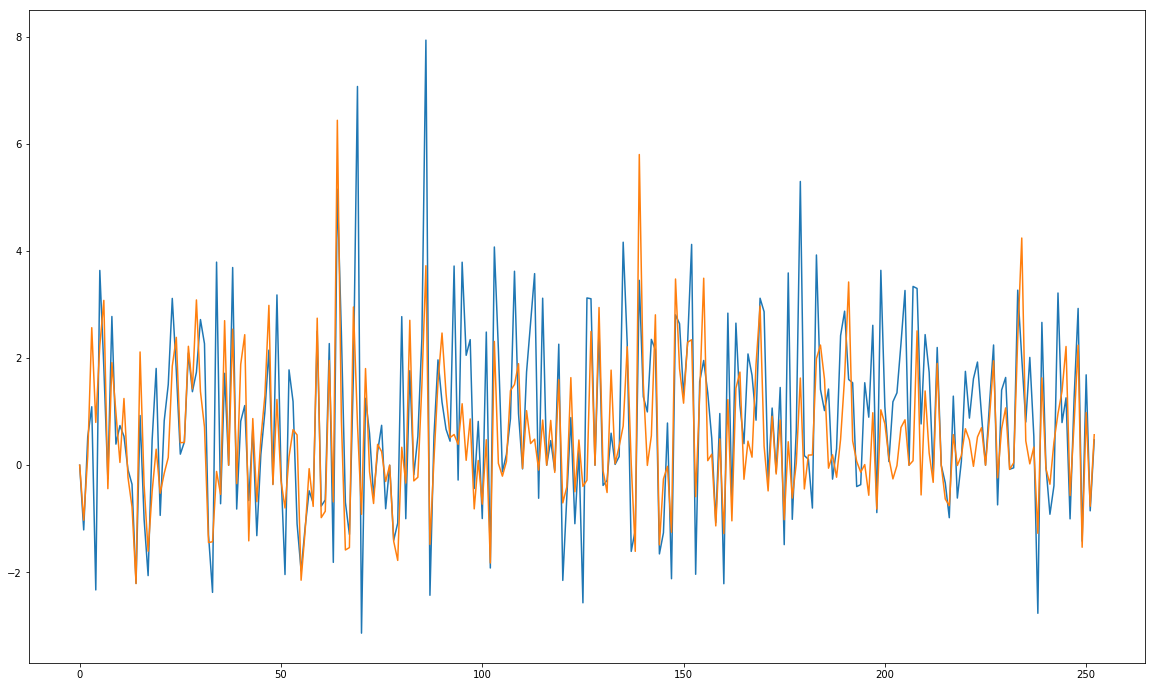

In [48]:
plt.plot(errs[0])
plt.plot(errs[-1])

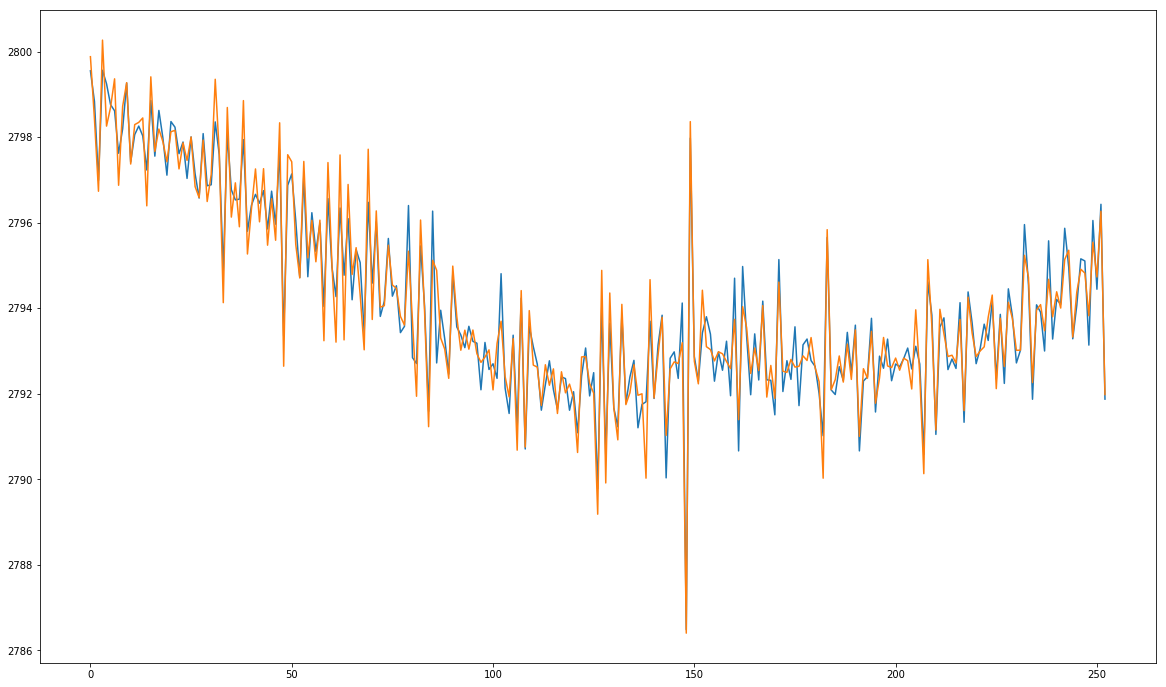

In [49]:
plt.plot(np.diff(lineinfo2))
plt.plot(np.diff(lineinfo_cur))

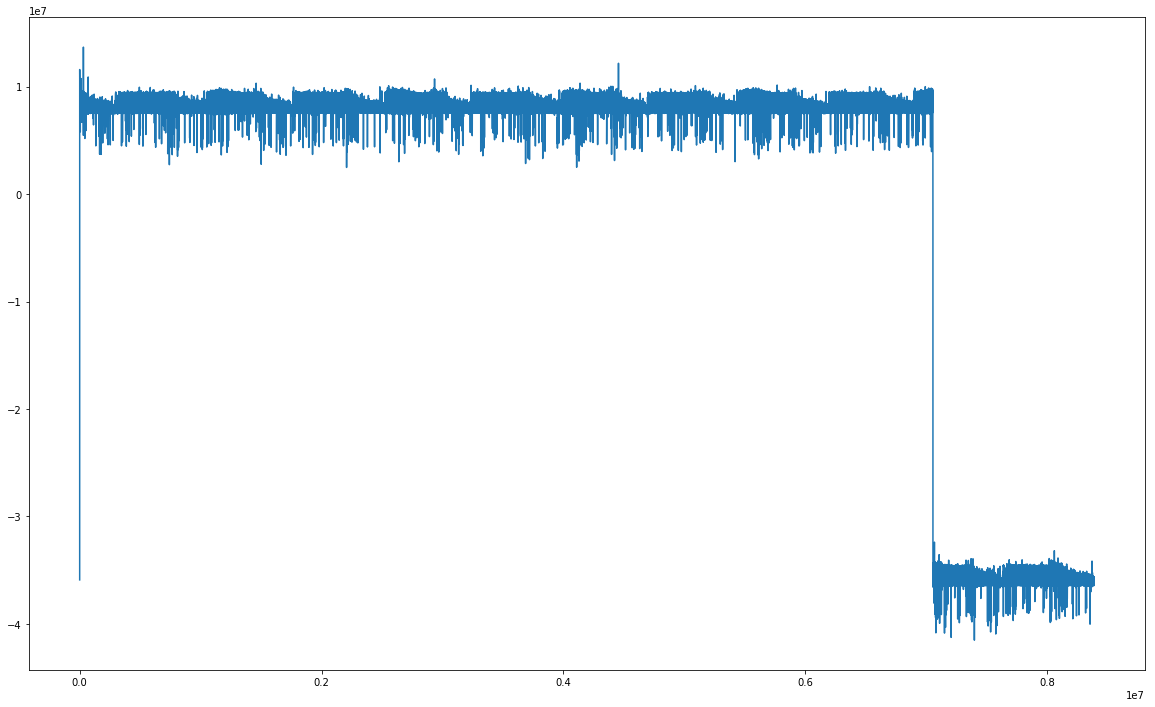

In [155]:
plt.plot(output)

In [22]:
len(output)

4194304

In [133]:
len(ocut)

4000000

In [136]:
cutlen = int(4000000 * (8 * 315/88 / 40))

In [137]:
o286_fft = np.fft.fft(ocut)

In [147]:

range(int(cutlen / 2), int(len(o286_fft) - (cutlen / 2)))

range(1431818, 2568182)

In [148]:
o286_fft_cut = np.delete(o286_fft, range(int(cutlen / 2), int(len(o286_fft) - (cutlen / 2))))

In [ ]:
output286 = np.fft.ifft(o286_fft_cut)

In [152]:
outfile = open('disco28.raw', 'wb')
outfile.write(output286)

45818176

In [82]:
output286 = scale(output, 94304, 8094304, 8000000 * (8 * 315/88) / 40)

/home/cpage/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


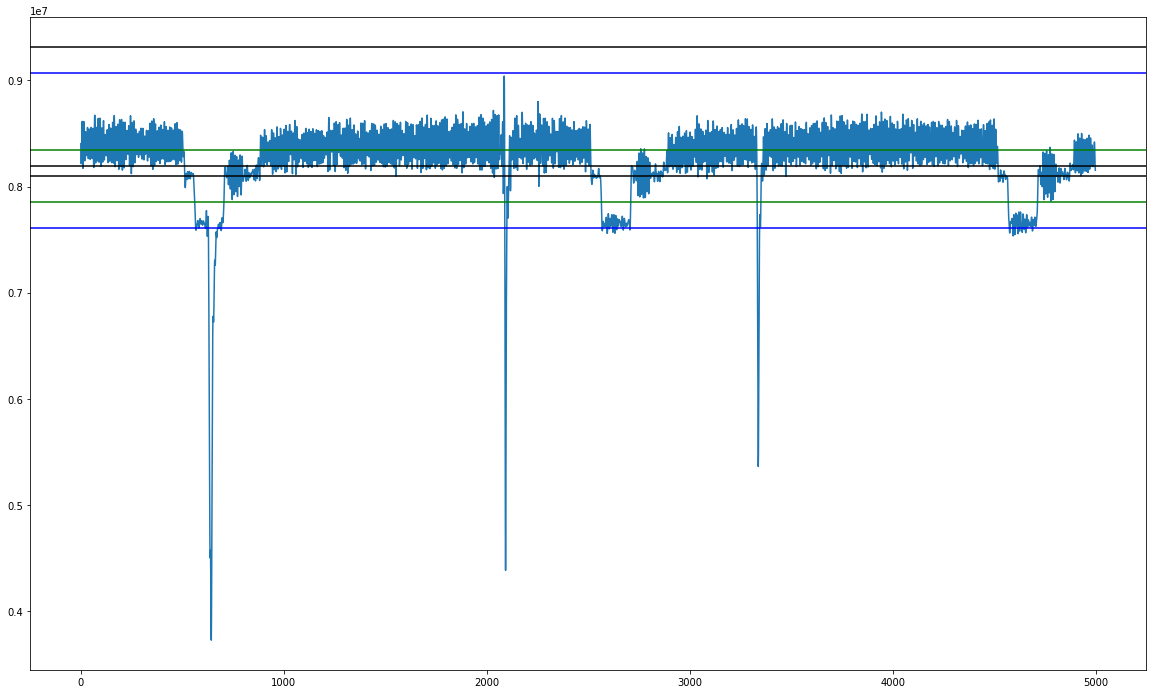

In [83]:
lineplot(output286[50000:55000], filterset)

In [119]:
# old lddecode format for hz->uint16 conversion
minire = -60
maxire = 140
hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [120]:
reduced = (output286 - minn) / hz_ire_scale
output16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)


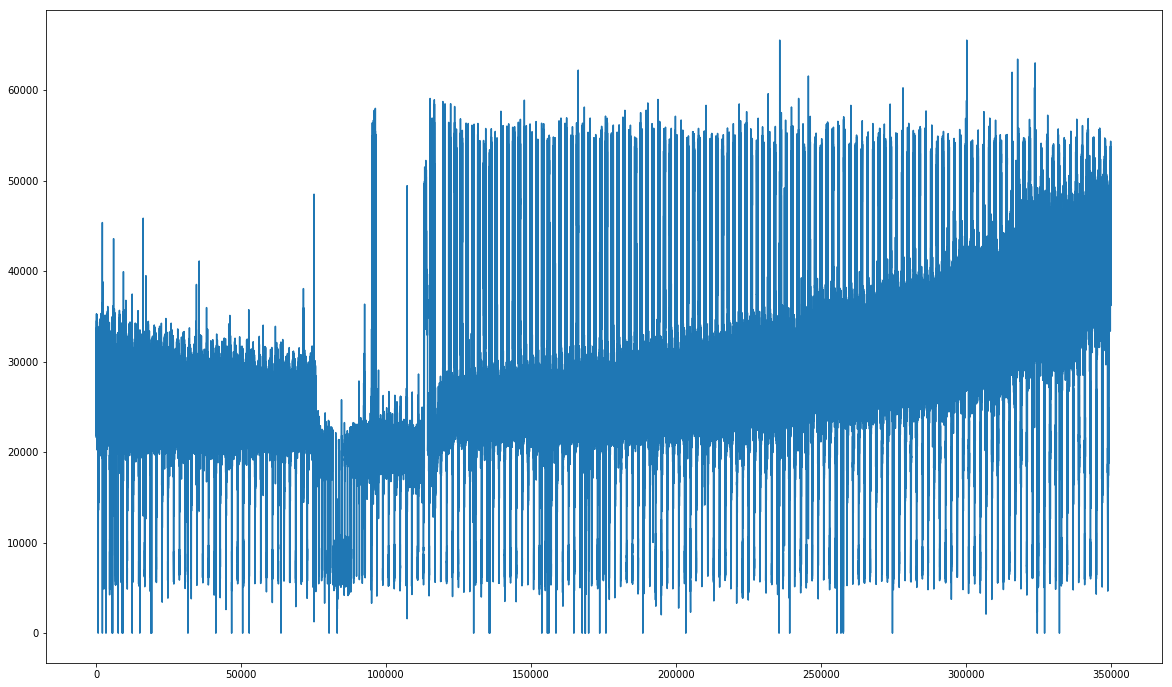

In [131]:
plt.plot(output16[50000:400000])

In [121]:
outfile = open('disco.ld', 'wb')
outfile.write(output16)

11454544

In [123]:
np.min(output16)

0

In [88]:
len(indata1)

16777216

In [92]:
cutlen = 64 * 1024

In [93]:
indata28 = scale(indata1, cutlen, len(indata1) - cutlen, (len(indata1) - (cutlen * 2)) * (8 * 315/88) / 40)


/home/cpage/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


In [116]:
indata28a = np.int16(np.clip(indata28, -32760, 32760))

In [117]:
np.min(indata28a)

-32760

In [118]:
outfile = open('disco28.raw', 'wb')
outfile.write(indata28a)

23834250

In [115]:
len(indata1)

16777216

In [96]:
(len(indata1) - (cutlen * 2)) * (8 * 315/88) / 40

11917125.818181818